In [2]:
from google.cloud import bigquery
import pandas as pd 
import chime   
import seaborn as sns
import pymc as pm
import numpy as np
client = bigquery.Client("gcp-wow-rwds-ai-checkout-dev")

/opt/homebrew/lib/python3.11/site-packages/google/auth/_default.py:78: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)

In [399]:
check = client.query(
"""
with step_one AS (
    SELECT 
        baseline.*,
        CASE WHEN test.test_store IS NULL THEN "Control" ELSE "Test" END AS test_or_control
    FROM gcp-wow-cart-data-dev-d4d7.davide.baseline_statistics_with_campaign_3 baseline
    LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.test_stores_2 test
        ON TRIM(test.booking_and_asset_number) = TRIM(baseline.campaign_id)
        AND TRIM(CAST(test.test_store AS STRING)) = TRIM(CAST(baseline.Site AS STRING))
    WHERE baseline.campaign_id = "WOW20002364_1"
)
SELECT 
    test_or_control,
    COUNT(DISTINCT Site) AS n_stores, 
    COUNT(DISTINCT CASE WHEN weeks_count = 13 THEN Site ELSE NULL END) AS has_13_wks_historical_sales
FROM step_one 
GROUP BY 1
"""
).result()
df = check.to_dataframe()
chime.success()
df


,test_or_control,n_stores,has_13_wks_historical_sales
0,Control,620,0
1,Test,128,0


In [396]:
check = client.query(
"""
SELECT * FROM gcp-wow-cart-data-dev-d4d7.davide.test_stores_2 LIMIT 10;
"""
).result()
df = check.to_dataframe()
chime.success()
df


,booking_number,booking_and_asset_number,test_store
0,WOW20002364,WOW20002364_1,1934
1,WOW20002364,WOW20002364_1,2682
2,WOW20002364,WOW20002364_1,2190
3,WOW20002364,WOW20002364_1,2939
4,WOW20002364,WOW20002364_1,3034
5,WOW20002364,WOW20002364_1,3211
6,WOW20002364,WOW20002364_1,4310
7,WOW20002364,WOW20002364_1,1306
8,WOW20002364,WOW20002364_1,1787
9,WOW20002364,WOW20002364_1,2690


In [398]:
check = client.query(
"""
SELECT * FROM gcp-wow-cart-data-dev-d4d7.davide.baseline_statistics_with_campaign_3 WHERE campaign_id = "WOW20002364_1" LIMIT 10;
"""
).result()
df = check.to_dataframe()
chime.success()
df


,campaign_id,Site,mean_transactions,sales_amount,stddev_transactions,stddev_sales_amount,variance_transactions,min_transactions,max_transactions,weeks_count,total_transactions
0,WOW20002364_1,3162,1.00,2.990000000,NaN,NaN,NaN,1,1,1,1
1,WOW20002364_1,3670,1.00,2.980000000,NaN,NaN,NaN,1,1,1,1
2,WOW20002364_1,2692,1.00,3.000000000,NaN,NaN,NaN,1,1,1,1
3,WOW20002364_1,3325,1.00,3.000000000,NaN,NaN,NaN,1,1,1,1
4,WOW20002364_1,2662,1.00,12.000000000,NaN,NaN,NaN,1,1,1,1
5,WOW20002364_1,1099,1.00,5.970000000,NaN,NaN,NaN,1,1,1,1
6,WOW20002364_1,4625,1.00,12.000000000,NaN,NaN,NaN,1,1,1,1
7,WOW20002364_1,4337,1.00,10.640000000,NaN,NaN,NaN,1,1,1,1
8,WOW20002364_1,2608,1.00,5.710000000,NaN,NaN,NaN,1,1,1,1
9,WOW20002364_1,4356,1.00,3.000000000,NaN,NaN,NaN,1,1,1,1


### Get Skus, Stores and Campaign Period Transactions

In [6]:
check = client.query(
"""
CREATE OR REPLACE TABLE gcp-wow-cart-data-dev-d4d7.davide.unique_skus_2 AS (
    SELECT DISTINCT 
        booking_and_asset_number, 
        sku 
    FROM gcp-wow-cart-data-dev-d4d7.davide.instore_screens_campaigns_june_2023_onwards_2, 
    UNNEST(SPLIT(quoteline_skus_string, ",")) AS sku 
    WHERE booking_and_asset_number = "WOW20001780_3" --current_campaign_global_var 
    AND sku IS NOT NULL
    AND LOWER(sku) <> "npd"
    AND sku <> ""
);

CREATE OR REPLACE TABLE gcp-wow-cart-data-dev-d4d7.davide.test_stores_2 AS (
    SELECT DISTINCT 
        booking_number, 
        booking_and_asset_number,
        test_store 
    FROM gcp-wow-cart-data-dev-d4d7.davide.instore_screens_campaigns_june_2023_onwards_2, 
    UNNEST(store_ids) AS test_store 
    WHERE booking_and_asset_number = "WOW20001780_3" --current_campaign_global_var
    AND test_store IS NOT NULL
);

CREATE OR REPLACE TABLE gcp-wow-cart-data-dev-d4d7.davide.regularization_test_campaign_period_transactions AS 
    SELECT 
        trading.booking_and_asset_number AS campaign_id,
        trading.media_start_date,
        trading.media_end_date,
        ass_campaign_period.Site, 
        CASE WHEN test_stores.test_store IS NOT NULL THEN "Test" ELSE "Control" END AS test_or_control, 
        --ass_campaign_period.Article,
        ass_campaign_period.TXNStartDate,
        ass_campaign_period.BasketKey,
        SUM(ass_campaign_period.TotalAmountIncldTax) AS sales_amount

    FROM `gcp-wow-ent-im-wowx-cust-prod.adp_wowx_dm_integrated_sales_view.article_sales_summary_v` ass_campaign_period
    LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.instore_screens_campaigns_june_2023_onwards_2 trading
        ON ass_campaign_period.TXNStartDate >= trading.media_start_date 
        AND ass_campaign_period.TXNStartDate <= trading.media_end_date 
    INNER JOIN gcp-wow-cart-data-dev-d4d7.davide.unique_skus_2 skus 
        ON skus.sku = ass_campaign_period.Article 
    LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.test_stores_2 test_stores 
        ON CAST(test_stores.test_store AS INT64) = CAST(ass_campaign_period.Site AS INT64)
        
    WHERE trading.booking_and_asset_number = "WOW20001780_3" --current_campaign_global_var
    AND LOWER(ass_campaign_period.SalesChannelDescription) <> "online"
    AND ass_campaign_period.TXNStartDate >= trading.media_start_date 
    AND ass_campaign_period.TXNStartDate <= trading.media_end_date
    AND ass_campaign_period.SalesOrg = 1005
    GROUP BY ALL
;

SELECT * FROM gcp-wow-cart-data-dev-d4d7.davide.regularization_test_campaign_period_transactions;
"""
).result()
transactions_df = check.to_dataframe()
chime.success()
transactions_df

,campaign_id,media_start_date,media_end_date,Site,test_or_control,TXNStartDate,BasketKey,sales_amount
0,WOW20001780_3,2023-05-31,2023-06-06,1280,Control,2023-05-31,20230531114426061027701280,19.500000000
1,WOW20001780_3,2023-05-31,2023-06-06,1280,Control,2023-05-31,20230531175921081016061280,6.960000000
2,WOW20001780_3,2023-05-31,2023-06-06,1280,Control,2023-05-31,20230531121053001085941280,19.400000000
3,WOW20001780_3,2023-05-31,2023-06-06,1280,Control,2023-05-31,20230531123617001086111280,3.480000000
4,WOW20001780_3,2023-05-31,2023-06-06,1280,Control,2023-05-31,20230531183350009097061280,6.970000000
...,...,...,...,...,...,...,...,...
401351,WOW20001780_3,2023-05-31,2023-06-06,5631,Test,2023-06-06,20230606130856002064625631,14.920000000
401352,WOW20001780_3,2023-05-31,2023-06-06,5631,Test,2023-06-06,20230606181130004091795631,3.410000000
401353,WOW20001780_3,2023-05-31,2023-06-06,5631,Test,2023-06-06,20230606145233007004435631,7.000000000
401354,WOW20001780_3,2023-05-31,2023-06-06,5631,Test,2023-06-06,20230606102011007002035631,9.950000000


In [ ]:
# Combine 'test_store' and 'control_store' into a single series
combined_stores = pd.concat([matched_pairs['test_store'], matched_pairs['control_store']])

# Filter transactions_df where 'Site' is in the combined stores
filtered_transactions = transactions_df[transactions_df['Site'].isin(combined_stores)]

### Historical Performance Data

In [ ]:
check = client.query(
"""
with step_one AS (
SELECT baseline.*, baseline.sales_amount / baseline.weeks_count AS weekly_avg_sales_amount, campaign.test_or_control --campaign_id, Site, stddev_sales_amount, sales_amount / weeks_count AS weekly_avg_sales_amount
FROM gcp-wow-cart-data-dev-d4d7.davide.baseline_statistics_with_campaign_3 baseline
LEFT JOIN (SELECT DISTINCT campaign_id, Site, test_or_control FROM gcp-wow-cart-data-dev-d4d7.davide.regularization_test_campaign_period_transactions) campaign
    ON baseline.campaign_id = campaign.campaign_id 
    AND baseline.Site = campaign.Site
WHERE baseline.campaign_id = "WOW20001780_3"
AND weeks_count = 13
) 
SELECT 
    test.campaign_id AS study_id, 
    test.Site AS test_store, 
    control.Site AS control_store, 
    ABS(test.weekly_avg_sales_amount / control.weekly_avg_sales_amount - 1) + ABS(test.stddev_sales_amount / control.stddev_sales_amount - 1) AS abs_perc_diff
FROM step_one test
LEFT JOIN step_one control 
    ON test.Site <> control.Site 
WHERE test.test_or_control = "Test" 
AND control.test_or_control = "Control" 
"""
).result()
historical_performance_df = check.to_dataframe()
chime.success()
historical_performance_df.to_csv("~/Downloads/Store_Pairs.csv", index = False)
historical_performance_df

#### Using the Exported CSV - Run the `match_maker.cpp` file using `./Match\ Maker/match_maker2 ~/Downloads/<your_file_name>.csv`

#### Then Load the `global_natching.csv` File

#### Reduce Transactions to Only the Unique Stores in Test & Control Matches

### Fit Posterior Distributions for the Total Sum of Sales in Each Store

In [ ]:

# Assuming you have a dataframe `df` with the SQL query results
df = check_df

# Convert sales_amount to numeric, forcing any errors to NaN and dropping them
df['sales_amount'] = pd.to_numeric(df['sales_amount'], errors='coerce')
df.dropna(subset=['sales_amount'], inplace=True)

# Group transactions by store (Site) for posterior modeling
grouped = df.groupby(['Site', 'test_or_control'])

# Initialize an empty dictionary to store full posterior samples for each store
posterior_samples = {}
count = 0
# Iterate through each group (store-level) and model the sum of sales as a posterior distribution
for store, group in grouped:
    sales = group['sales_amount'].values  # extract individual transaction sales for the store
    count = count + 1
    # Check if sales is empty or non-numeric (additional guard)
    if len(sales) == 0 or not np.issubdtype(sales.dtype, np.number):
        
        print(f"Skipping store {store} due to invalid sales data")
        continue

    # Bayesian modeling of the sum of sales
    with pm.Model() as model:
        # Total number of transactions
        n_sales = len(sales)

        # Flat prior for the mean of the total sales across all transactions
        total_sum_sales = pm.Uniform("total_sum_sales", lower=n_sales * sales.min(), upper=n_sales * sales.max())

        # Per-transaction mean derived from the total sum
        per_transaction_mu = total_sum_sales / n_sales
        
        # Flat prior for the standard deviation of the sales per transaction
        sigma = pm.Uniform("sigma", lower=0, upper=sales.std() * 2)
        
        # Likelihood of observing sales per transaction
        sales_obs = pm.Normal("sales_obs", mu=per_transaction_mu, sigma=sigma, observed=sales)
        
        # Sampling from the posterior with increased tuning and sample size
        trace = pm.sample(2000, tune=2000, target_accept=0.95, return_inferencedata=True, progressbar=False)

        # Store the full posterior samples for the total sum of sales
        posterior_samples[store] = trace.posterior['total_sum_sales'].to_dataframe()
        print(f"{count} stores fit with posteriors\n")

# Convert the posterior samples into a dictionary for each store
# The key will be the store and the value will be a DataFrame of posterior samples
posterior_samples_dict = {store: df.reset_index(drop=True) for store, df in posterior_samples.items()}

# Example output for a specific store (the first one in the dictionary)
store_name = list(posterior_samples_dict.keys())[0]
print(f"Posterior samples for store {store_name}:\n", posterior_samples_dict[store_name].head())

# You can now use posterior_samples_dict in your downstream hierarchical model


### Flatten Posterior Samples Dict to a Dataframe

In [32]:
# Step 1: Flatten the posterior_samples_dict into a DataFrame
# We will stack the store IDs and their corresponding posterior samples

flattened_samples = []
for store, posterior_df in posterior_samples.items():
    store_id = store[0]  # Extract the store ID
    test_or_control = store[1]  # Extract test or control group info
    posterior_df = posterior_df.reset_index(drop=True)  # Reset the index of the posterior samples
    posterior_df['store'] = store_id  # Add the store ID as a column
    posterior_df['test_or_control'] = test_or_control  # Add the test or control info
    flattened_samples.append(posterior_df)

# Concatenate all store samples into a single DataFrame
flattened_samples_df = pd.concat(flattened_samples, ignore_index=True)


### Inspect Posterior Samples Dataframe

In [35]:
flattened_samples_df.head(5)

,total_sum_sales,store,test_or_control
0,3876.119796,1002,Test
1,3930.321943,1002,Test
2,4219.651964,1002,Test
3,4056.686709,1002,Test
4,3850.153902,1002,Test


### Retrieve Store Level Historical Performance Data

In [58]:
check = client.query(
"""
with step_one AS (
SELECT baseline.*, baseline.sales_amount / baseline.weeks_count AS weekly_avg_sales_amount, campaign.test_or_control --campaign_id, Site, stddev_sales_amount, sales_amount / weeks_count AS weekly_avg_sales_amount
FROM gcp-wow-cart-data-dev-d4d7.davide.baseline_statistics_with_campaign_3 baseline
LEFT JOIN (SELECT DISTINCT campaign_id, Site, test_or_control FROM gcp-wow-cart-data-dev-d4d7.davide.regularization_test_campaign_period_transactions) campaign
    ON baseline.campaign_id = campaign.campaign_id 
    AND baseline.Site = campaign.Site
WHERE baseline.campaign_id = "WOW20001780_3"
AND weeks_count = 13
) 
SELECT 
    test_or_control, 
    COUNT(DISTINCT Site) AS n_stores 
FROM step_one 
GROUP BY 1
"""
).result()
historical_performance_df = check.to_dataframe()
chime.success()
historical_performance_df

,test_or_control,n_stores
0,Test,929
1,Control,76


In [55]:
matched_pairs = pd.read_csv("../global_matching.csv")
matched_pairs.head(10)

,test_store,control_store,abs_perc_diff
0,1387,5661,0.000729
1,4630,2763,0.003147
2,1102,2687,0.004455
3,5731,1111,0.004611
4,1253,2661,0.005027
5,3400,2646,0.005028
6,3007,5615,0.005902
7,2564,3275,0.005963
8,3229,3802,0.006183
9,1262,2667,0.006524


### Merging Historical Campaign Performance Data

In [43]:
# Assuming you have two DataFrames:
# flattened_samples_df: Contains store, test_or_control, total_sum_sales
# campaign_data_df: Contains campaign_id, Site (store), stddev_sales_amount, weekly_avg_sales_amt

# Perform a left join
merged_df = pd.merge(flattened_samples_df, 
                     historical_performance_df[['campaign_id', 'Site', 'stddev_sales_amount', 'weekly_avg_sales_amount']],
                     left_on='store', right_on='Site', how='left')

# Drop the redundant 'Site' column (if needed)
merged_df = merged_df.drop(columns=['Site'])

# Output the merged DataFrame
merged_df.head(5)

# Now merged_df contains the structure you wanted:
# campaign_id, store, test_or_control, total_sum_sales, weekly_avg_sales_amt, stddev_sales_amt


,total_sum_sales,store,test_or_control,campaign_id,stddev_sales_amount,weekly_avg_sales_amount
0,3876.119796,1002,Test,WOW20001780_3,388.160835,2457.790769231
1,3930.321943,1002,Test,WOW20001780_3,388.160835,2457.790769231
2,4219.651964,1002,Test,WOW20001780_3,388.160835,2457.790769231
3,4056.686709,1002,Test,WOW20001780_3,388.160835,2457.790769231
4,3850.153902,1002,Test,WOW20001780_3,388.160835,2457.790769231


### Adding Campaign Week Z-Score

In [46]:
# Convert 'total_sum_sales', 'weekly_avg_sales_amt', and 'stddev_sales_amount' to float
merged_df['total_sum_sales'] = merged_df['total_sum_sales'].astype(float)
merged_df['weekly_avg_sales_amount'] = merged_df['weekly_avg_sales_amount'].astype(float)
merged_df['stddev_sales_amount'] = merged_df['stddev_sales_amount'].astype(float)

# Ensure there are no zero values in stddev_sales_amt to avoid division errors
merged_df['stddev_sales_amount'].replace(0, np.nan, inplace=True)

# Calculate the campaign_z_score and create a new column
merged_df['campaign_z_score'] = (merged_df['total_sum_sales'] - merged_df['weekly_avg_sales_amount']) / merged_df['stddev_sales_amount']

# Output the resulting DataFrame with the new column
merged_df.head(5)


,total_sum_sales,store,test_or_control,campaign_id,stddev_sales_amount,weekly_avg_sales_amount,campaign_z_score
0,3876.119796,1002,Test,WOW20001780_3,388.160835,2457.790769,3.653973
1,3930.321943,1002,Test,WOW20001780_3,388.160835,2457.790769,3.793611
2,4219.651964,1002,Test,WOW20001780_3,388.160835,2457.790769,4.538998
3,4056.686709,1002,Test,WOW20001780_3,388.160835,2457.790769,4.119158
4,3850.153902,1002,Test,WOW20001780_3,388.160835,2457.790769,3.587078


In [384]:
# Import necessary libraries
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az

# Assume 'merged_df' and 'matched_pairs' DataFrames are already loaded and preprocessed
# 'merged_df' contains columns: 'store', 'test_or_control', 'campaign_z_score'
# 'matched_pairs' contains columns: 'test_store', 'control_store'

# Ensure 'merged_df' is sorted by 'store' and 'test_or_control'
merged_df = merged_df.sort_values(by=['store', 'test_or_control'])

# Initialize a list to store the posterior samples of percentage differences
posterior_percentage_differences = []

# Set a small constant to handle division by zero in percentage difference calculation
epsilon = 1e-6

# Iterate through each pair of test and control stores in 'matched_pairs'
for _, pair in matched_pairs.iterrows():
    test_store = pair['test_store']
    control_store = pair['control_store']
    
    # Extract posterior samples of z-scores for test and control stores
    test_store_posteriors = merged_df[merged_df['store'] == test_store]['campaign_z_score'].values
    control_store_posteriors = merged_df[merged_df['store'] == control_store]['campaign_z_score'].values
    
    # Ensure that the number of posterior samples matches between test and control stores
    if len(test_store_posteriors) != len(control_store_posteriors):
        raise ValueError(f"Mismatch in posterior sample sizes between test store {test_store} and control store {control_store}")
    
    # Compute the percentage difference using the original formula
    # Handle small denominators by adding epsilon
    with np.errstate(divide='ignore', invalid='ignore'):
        perc_diff = (test_store_posteriors - control_store_posteriors) / (np.abs(control_store_posteriors))
    
    # Store the percentage difference samples along with the test and control store ids
    posterior_percentage_differences.append(pd.DataFrame({
        'test_store': test_store,
        'control_store': control_store,
        'posterior_perc_diff': perc_diff
    }))

# Concatenate all the percentage difference DataFrames
posterior_percentage_differences_df = pd.concat(posterior_percentage_differences, ignore_index=True)

# Create an index that identifies which pair each percentage difference belongs to
pair_labels = posterior_percentage_differences_df.apply(lambda row: (row['test_store'], row['control_store']), axis=1)

# Create a categorical variable to get codes for each unique pair
pair_categories = pd.Categorical(pair_labels)
pair_indices = pair_categories.codes  # This will map each observation to a store pair index
unique_pairs = pair_categories.categories

# Now fit the hierarchical Bayesian model with adjusted priors
with pm.Model() as model:
    # Prior for the global mean percentage difference (mu_pop)
    # Centered at 0.0 with a wider standard deviation to allow for both positive and negative effects
    mu_pop = pm.Normal('mu_pop', mu=0.0, sigma=0.005)
    
    # Prior for the variability of store pair effects around the global mean (sigma_pop)
    sigma_pop = pm.HalfNormal('sigma_pop', sigma=0.00088)
    
    # Store-pair-specific effects (using centered parameterization)
    store_pair_effects = pm.Normal('store_pair_effects', mu=mu_pop, sigma=sigma_pop, shape=len(unique_pairs))
    
    # Assign the correct store_pair_effect to each percentage difference using pair_indices
    store_pair_effects_repeated = store_pair_effects[pair_indices]
    
    # Prior for the observational standard deviation (sigma_obs)
    sigma_obs = pm.HalfNormal('sigma_obs', sigma=0.005)
    
    # Likelihood: Using normal distribution
    observed_perc_diff = pm.Normal(
        'observed_perc_diff',
        mu=store_pair_effects_repeated,
        sigma=sigma_obs,
        observed=posterior_percentage_differences_df['posterior_perc_diff'].values
    )
    
    # Sample from the posterior distribution
    trace = pm.sample(
        draws=2000,
        tune=2000,
        target_accept=0.95,
        return_inferencedata=True
    )

# Summarize and analyze the trace
summary_df = az.summary(
    trace,
    var_names=['mu_pop', 'sigma_pop', 'sigma_obs', 'store_pair_effects'],
    hdi_prob=0.95
)

# Map store pairs to store_pair_effects for easier interpretation
store_pair_mapping = {f"store_pair_effects[{i}]": unique_pairs[i] for i in range(len(unique_pairs))}

# Replace the index in summary_df with the store pair labels
summary_df = summary_df.rename(index=store_pair_mapping)

# Convert 'mu_pop' and 'store_pair_effects' to percentages
summary_df.loc['mu_pop', ['mean', 'sd', 'hdi_2.5%', 'hdi_97.5%']] *= 100

# Since store pair labels are tuples, format them as strings for readability
summary_df.index = summary_df.index.map(lambda x: f"{int(x[0])}_{int(x[1])}" if isinstance(x, tuple) else x)

# Multiply store_pair_effects by 100 to get percentages
store_pair_indices = [i for i in summary_df.index if i not in ['mu_pop', 'sigma_pop', 'sigma_obs']]
summary_df.loc[store_pair_indices, ['mean', 'sd', 'hdi_2.5%', 'hdi_97.5%']] *= 100

# Output the summary DataFrame with relevant columns
print(summary_df[['mean', 'sd', 'hdi_2.5%', 'hdi_97.5%']])


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_pop, sigma_pop, store_pair_effects, sigma_obs]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 924 seconds.


            mean    sd  hdi_2.5%  hdi_97.5%
mu_pop      4.60  0.50      3.60       5.50
sigma_pop   0.05  0.00      0.04       0.05
sigma_obs  14.85  0.00     14.85      14.86
1030_1280   4.00  4.40     -4.40      12.60
1034_4600   7.20  4.40     -1.60      15.80
1063_2621   1.50  4.50     -7.00      10.70
1102_2687   0.60  4.50     -8.20       9.50
1112_1380   5.10  4.40     -3.70      13.60
1124_2600   4.30  4.40     -4.40      13.00
1167_1288   1.20  4.50     -7.60      10.20
1174_3221   6.70  4.50     -2.10      15.20
1189_2555   4.80  4.40     -4.00      13.40
1206_1603   2.80  4.40     -6.00      11.20
1253_2661   4.50  4.50     -4.80      12.80
1262_2667   1.60  4.40     -7.00      10.10
1287_2665   4.50  4.40     -4.00      13.10
1343_1800 130.30  9.60    111.80     148.90
1387_5661  15.80  4.40      6.90      24.20
1446_3092  32.80  4.90     23.30      42.30
1614_2726   3.40  4.50     -5.20      12.30
1632_3141   4.50  4.40     -4.30      13.20
1647_1092   3.60  4.40     -4.70

In [385]:
# Convert the index into a DataFrame for easier handling
summary_df = summary_df.reset_index()

# Separate rows where the index is not a store pair (e.g., 'mu_pop', 'sigma_pop')
non_store_rows = summary_df[summary_df['index'].isin(['mu_pop', 'sigma_pop', 'sigma_obs'])]

# Filter out only the store pair rows for processing
store_pair_rows = summary_df[~summary_df['index'].isin(['mu_pop', 'sigma_pop', 'sigma_obs'])]

# Extract test_store and control_store from the store pair rows
store_pair_rows[['test_store', 'control_store']] = store_pair_rows['index'].str.extract(r'(\d+\.?\d*)\_(\d+\.?\d*)')

# Convert store IDs to integers
store_pair_rows['test_store'] = store_pair_rows['test_store'].astype(float).astype(int)
store_pair_rows['control_store'] = store_pair_rows['control_store'].astype(float).astype(int)

# Drop the original 'index' column from store pair rows
store_pair_rows.drop(columns=['index'], inplace=True)

# Combine the population-level rows back with the processed store pair rows
summary_df_processed = pd.concat([non_store_rows, store_pair_rows], ignore_index=True)

# Display the processed DataFrame
summary_df_processed

/var/folders/pz/tmsv9qjs4g36095qthg4dsw80000gn/T/ipykernel_36935/2717524552.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  store_pair_rows[['test_store', 'control_store']] = store_pair_rows['index'].str.extract(r'(\d+\.?\d*)\_(\d+\.?\d*)')
/var/folders/pz/tmsv9qjs4g36095qthg4dsw80000gn/T/ipykernel_36935/2717524552.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  store_pair_rows[['test_store', 'control_store']] = store_pair_rows['index'].str.extract(r'(\d+\.?\d*)\_(\d+\.?\d*)')
/var/folders/pz/tmsv

,index,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,test_store,control_store
0,mu_pop,4.60,0.50,3.60,5.50,0.00,0.00,"8,698.00","6,078.00",1.00,NaN,NaN
1,sigma_pop,0.05,0.00,0.04,0.05,0.00,0.00,"4,106.00","3,803.00",1.00,NaN,NaN
2,sigma_obs,14.85,0.00,14.85,14.86,0.00,0.00,"14,019.00","6,004.00",1.00,NaN,NaN
3,NaN,4.00,4.40,-4.40,12.60,0.00,0.00,"14,282.00","5,817.00",1.00,"1,030.00","1,280.00"
4,NaN,7.20,4.40,-1.60,15.80,0.00,0.00,"13,438.00","5,734.00",1.00,"1,034.00","4,600.00"
5,NaN,1.50,4.50,-7.00,10.70,0.00,0.00,"14,147.00","5,915.00",1.00,"1,063.00","2,621.00"
6,NaN,0.60,4.50,-8.20,9.50,0.00,0.00,"15,012.00","5,888.00",1.00,"1,102.00","2,687.00"
7,NaN,5.10,4.40,-3.70,13.60,0.00,0.00,"15,818.00","6,145.00",1.00,"1,112.00","1,380.00"
8,NaN,4.30,4.40,-4.40,13.00,0.00,0.00,"15,122.00","5,774.00",1.00,"1,124.00","2,600.00"
9,NaN,1.20,4.50,-7.60,10.20,0.00,0.00,"14,449.00","5,675.00",1.00,"1,167.00","1,288.00"


In [416]:
pd.set_option('display.float_format', '{:,.2f}'.format)
check = client.query(
f"""
with step_one AS (
    SELECT 
        test.campaign_id, 
        test.Site AS test_store, 
        control.Site AS control_store, 
        test.total_sales_campaign_period AS test_campaign_sales,
        control.total_sales_campaign_period AS control_campaign_sales, 
        SAFE_DIVIDE(test.mean_sales_amount , test.weeks_count) AS test_weekly_avg_sales_amt, 
        SAFE_DIVIDE(control.mean_sales_amount , control.weeks_count) AS control_weekly_avg_sales_amt, 
        test.stddev_sales_amount AS test_stddev_sales_amt, 
        control.stddev_sales_amount AS control_stddev_sales_amt, 
        SAFE_DIVIDE((test.total_sales_campaign_period - SAFE_DIVIDE(test.mean_sales_amount , test.weeks_count)) , test.stddev_sales_amount) AS test_z_score, 
        SAFE_DIVIDE((control.total_sales_campaign_period - SAFE_DIVIDE(control.mean_sales_amount , control.weeks_count)) , control.stddev_sales_amount) AS control_z_score
    FROM gcp-wow-cart-data-dev-d4d7.davide.instore_screens_sales_pre_vs_during_period_plus_baseline_4 test 
    LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.instore_screens_sales_pre_vs_during_period_plus_baseline_4 control
        ON test.Site <> control.Site 
    WHERE test.campaign_id = 'WOW20001780_3'
    AND control.campaign_id = 'WOW20001780_3'
    AND test.test_or_control = "Test" 
    AND control.test_or_control = "Control" 
    AND test.weeks_count = 13
    AND control.weeks_count = 13
) 
SELECT 
    *, 
    CASE WHEN test_z_score < 0 OR control_z_score < 0 THEN ((SAFE_DIVIDE(test_z_score , control_z_score) - 1) * -1) * 100 ELSE (SAFE_DIVIDE(test_z_score , control_z_score) -1) * 100 END AS z_score_perc_diff_old,
    (test_z_score - control_z_score) / ABS(control_z_score) AS z_score_perc_diff_equivalent,
    (test_z_score - control_z_score) / (ABS(test_z_score) + ABS(control_z_score)) AS z_score_perc_diff_new, 
    (((test_z_score * test_weekly_avg_sales_amt) - test_weekly_avg_sales_amt) / test_weekly_avg_sales_amt) - 1 AS test_percentage_increase_vs_expectation,
    (((control_z_score * control_weekly_avg_sales_amt) - control_weekly_avg_sales_amt) / control_weekly_avg_sales_amt) -1 AS control_percentage_increase_vs_expectation,
    (((test_z_score - control_z_score) * test_weekly_avg_sales_amt) - test_weekly_avg_sales_amt) / test_weekly_avg_sales_amt AS test_increase,
    (((control_z_score - test_z_score) * control_weekly_avg_sales_amt) - control_weekly_avg_sales_amt) / control_weekly_avg_sales_amt AS control_increase
FROM step_one
"""
).result()
check_df = check.to_dataframe()
chime.success() 
result_df = check_df.merge(matched_pairs, on=['test_store', 'control_store'], how='inner')
result_df

,campaign_id,test_store,control_store,test_campaign_sales,control_campaign_sales,test_weekly_avg_sales_amt,control_weekly_avg_sales_amt,test_stddev_sales_amt,control_stddev_sales_amt,test_z_score,control_z_score,z_score_perc_diff_old,z_score_perc_diff_equivalent,z_score_perc_diff_new,test_percentage_increase_vs_expectation,control_percentage_increase_vs_expectation,test_increase,control_increase,abs_perc_diff
0,WOW20001780_3,2564,3275,6303.610000000,5623.530000000,"4,755.99","4,757.87",922.44,927.61,1.68,0.93,79.78,0.80,0.29,-0.32,-1.07,-0.26,-1.74,0.01
1,WOW20001780_3,1034,4600,2373.370000000,2026.800000000,"1,387.50","1,334.95",327.63,315.72,3.01,2.19,37.31,0.37,0.16,1.01,0.19,-0.18,-1.82,0.08
2,WOW20001780_3,3007,5615,3084.710000000,3000.330000000,"2,111.93","2,122.77",437.77,438.12,2.22,2.00,10.94,0.11,0.05,0.22,0.00,-0.78,-1.22,0.01
3,WOW20001780_3,5736,3193,4036.530000000,4160.360000000,"2,931.44","2,935.56",538.42,545.88,2.05,2.24,-8.52,-0.09,-0.04,0.05,0.24,-1.19,-0.81,0.02
4,WOW20001780_3,4313,3161,5510.650000000,4930.540000000,"3,723.65","3,664.24",566.73,556.90,3.15,2.27,38.67,0.39,0.16,1.15,0.27,-0.12,-1.88,0.03
5,WOW20001780_3,1647,1092,7216.740000000,7499.860000000,"5,171.05","5,218.80",993.13,991.10,2.06,2.30,-10.50,-0.11,-0.06,0.06,0.30,-1.24,-0.76,0.01
6,WOW20001780_3,3604,2512,3225.640000000,3289.660000000,"2,504.34","2,501.96",474.65,479.89,1.52,1.64,-7.42,-0.07,-0.04,-0.48,-0.36,-1.12,-0.88,0.01
7,WOW20001780_3,3400,2646,4257.800000000,4066.010000000,"2,952.11","2,959.61",767.86,769.77,1.70,1.44,18.31,0.18,0.08,-0.30,-0.56,-0.74,-1.26,0.01
8,WOW20001780_3,3195,1156,1878.770000000,2194.750000000,"1,466.58","1,486.53",280.55,247.77,1.47,2.86,-48.60,-0.49,-0.32,-0.53,0.86,-2.39,0.39,0.15
9,WOW20001780_3,1167,1288,4813.530000000,5882.680000000,"3,484.96","3,511.03",840.90,836.37,1.58,2.84,-44.28,-0.44,-0.28,-0.42,0.84,-2.26,0.26,0.01


In [400]:
# Assuming merged_df contains 'test_store', 'control_store', and 'empirical_percentage_diff'
# Ensure that 'test_store' and 'control_store' in merged_df are integers for joining
#result_df['test_store'] = result_df['test_store'].astype(int)
#result_df['control_store'] = result_df['control_store'].astype(int)
#result_df['z_score_perc_diff_equivalent'] = result_df['z_score_perc_diff_equivalent'] * 100
pd.set_option('display.float_format', '{:,.2f}'.format)
# Join the processed summary dataframe with the merged_df on test_store and control_store
comparison_df = pd.merge(
    summary_df_processed[['test_store', 'control_store', 'mean']],
    result_df[['test_store', 'control_store', 'z_score_perc_diff_equivalent']],  # Keep the relevant columns from merged_df
    on=['test_store', 'control_store'],
    how='left'
)

# Rename the columns for clarity
comparison_df = comparison_df.rename(columns={
    'mean': 'pymc_percentage_diff',
    'empirical_percentage_diff': 'empirical_percentage_diff'
})

# Display the merged dataframe for comparison
comparison_df['pymc_percentage_diff'] = comparison_df['pymc_percentage_diff'].round(2)
# Adding the campaign_id column to the DataFrame
comparison_df.insert(0, 'campaign_id', 'WOW20001780_3')

# Display the updated DataFrame
print(comparison_df)



      campaign_id  test_store  control_store  pymc_percentage_diff  \
0   WOW20001780_3         NaN            NaN                  4.60   
1   WOW20001780_3         NaN            NaN                  0.05   
2   WOW20001780_3         NaN            NaN                 14.85   
3   WOW20001780_3    1,030.00       1,280.00                  4.00   
4   WOW20001780_3    1,034.00       4,600.00                  7.20   
5   WOW20001780_3    1,063.00       2,621.00                  1.50   
6   WOW20001780_3    1,102.00       2,687.00                  0.60   
7   WOW20001780_3    1,112.00       1,380.00                  5.10   
8   WOW20001780_3    1,124.00       2,600.00                  4.30   
9   WOW20001780_3    1,167.00       1,288.00                  1.20   
10  WOW20001780_3    1,174.00       3,221.00                  6.70   
11  WOW20001780_3    1,189.00       2,555.00                  4.80   
12  WOW20001780_3    1,206.00       1,603.00                  2.80   
13  WOW20001780_3   

In [405]:
test_comparison_df = comparison_df
# Step 1: Identify the rows to keep (excluding sigma parameter rows)
rows_to_keep = test_comparison_df.groupby('campaign_id').apply(lambda x: pd.concat([x.iloc[[0]], x.iloc[3:]]))
test_comparison_df = rows_to_keep.reset_index(drop=True)

# Step 2: Identify the "mu_pop" rows
mu_pop_mask = test_comparison_df['test_store'].isna() & test_comparison_df['control_store'].isna() & test_comparison_df['pymc_percentage_diff'].notna()

# Step 3: Fill in "mu_pop" for test_store and control_store in these rows
test_comparison_df.loc[mu_pop_mask, ['test_store', 'control_store']] = 'mu_pop'

# Step 4: Calculate the mean of z_score_perc_diff_equivalent for each campaign_id
# Exclude the mu_pop rows from this calculation
z_score_means = test_comparison_df[~mu_pop_mask].groupby('campaign_id')['z_score_perc_diff_equivalent'].mean()

# Step 5: Update the z_score_perc_diff_equivalent for the "mu_pop" rows with this mean
test_comparison_df.loc[mu_pop_mask, 'z_score_perc_diff_equivalent'] = test_comparison_df.loc[mu_pop_mask, 'campaign_id'].map(z_score_means)

# Display the updated dataframe
test_comparison_df

,campaign_id,test_store,control_store,pymc_percentage_diff,z_score_perc_diff_equivalent
0,WOW20001780_3,mu_pop,mu_pop,4.60,17.50
1,WOW20001780_3,"1,030.00","1,280.00",4.00,-6.66
2,WOW20001780_3,"1,034.00","4,600.00",7.20,37.31
3,WOW20001780_3,"1,063.00","2,621.00",1.50,-39.23
4,WOW20001780_3,"1,102.00","2,687.00",0.60,-52.74
5,WOW20001780_3,"1,112.00","1,380.00",5.10,6.72
6,WOW20001780_3,"1,124.00","2,600.00",4.30,-0.97
7,WOW20001780_3,"1,167.00","1,288.00",1.20,-44.28
8,WOW20001780_3,"1,174.00","3,221.00",6.70,30.96
9,WOW20001780_3,"1,189.00","2,555.00",4.80,6.80


In [406]:
test_comparison_df.to_csv("~/Downloads/Regularization.csv", index=False)

In [401]:
print(comparison_df.to_markdown())

|    | campaign_id   |   test_store |   control_store |   pymc_percentage_diff |   z_score_perc_diff_equivalent |
|---:|:--------------|-------------:|----------------:|-----------------------:|-------------------------------:|
|  0 | WOW20001780_3 |          nan |             nan |                   4.6  |                     nan        |
|  1 | WOW20001780_3 |          nan |             nan |                   0.05 |                     nan        |
|  2 | WOW20001780_3 |          nan |             nan |                  14.85 |                     nan        |
|  3 | WOW20001780_3 |         1030 |            1280 |                   4    |                      -6.6555   |
|  4 | WOW20001780_3 |         1034 |            4600 |                   7.2  |                      37.3145   |
|  5 | WOW20001780_3 |         1063 |            2621 |                   1.5  |                     -39.2336   |
|  6 | WOW20001780_3 |         1102 |            2687 |                   0.6  |        

#### Plot Specific Matched Pair Distribution of Total Sum of Sales

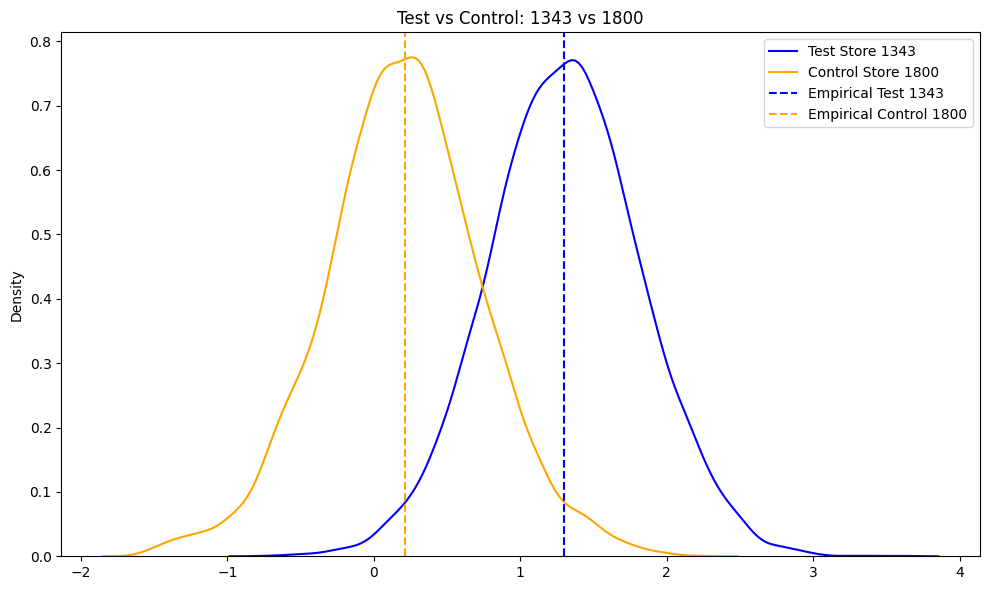

In [378]:
import matplotlib.pyplot as plt
import seaborn as sns

# Specify the exact test and control stores
specific_test_store = 1343
specific_control_store = 1800

# Filter the matched_pairs dataframe to focus on the specific pair
specific_pair = matched_pairs[
    (matched_pairs['test_store'] == specific_test_store) & 
    (matched_pairs['control_store'] == specific_control_store)
]

# Ensure the pair exists
if not specific_pair.empty:
    # Create a figure for this specific pair
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Extract posterior distributions of sum_total_sales from merged_df for both test and control stores
    test_store_posteriors = merged_df[merged_df['store'] == specific_test_store]['campaign_z_score'].values
    control_store_posteriors = merged_df[merged_df['store'] == specific_control_store]['campaign_z_score'].values
    
    # Extract empirical values from check_df
    test_empirical = check_df[check_df['test_store'] == specific_test_store]['test_z_score'].values[0]
    control_empirical = check_df[check_df['control_store'] == specific_control_store]['control_z_score'].values[0]
    
    # Plot the posterior distributions for the test and control stores
    sns.kdeplot(test_store_posteriors, ax=ax, label=f'Test Store {specific_test_store}', color='blue')
    sns.kdeplot(control_store_posteriors, ax=ax, label=f'Control Store {specific_control_store}', color='orange')
    
    # Plot the empirical points as vertical lines
    ax.axvline(test_empirical, color='blue', linestyle='--', label=f'Empirical Test {specific_test_store}')
    ax.axvline(control_empirical, color='orange', linestyle='--', label=f'Empirical Control {specific_control_store}')
    
    # Set title and legend
    ax.set_title(f'Test vs Control: {specific_test_store} vs {specific_control_store}', fontsize=12)
    ax.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

else:
    print(f"No match found for Test Store: {specific_test_store} and Control Store: {specific_control_store}")


In [441]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az

def preprocess_data(merged_df, matched_pairs):
    posterior_percentage_differences = []
    epsilon = 1e-6

    for _, pair in matched_pairs.iterrows():
        test_store = pair['test_store']
        control_store = pair['control_store']
        
        test_store_posteriors = merged_df[merged_df['store'] == test_store]['campaign_z_score'].values
        control_store_posteriors = merged_df[merged_df['store'] == control_store]['campaign_z_score'].values
        
        if len(test_store_posteriors) != len(control_store_posteriors):
            raise ValueError(f"Mismatch in posterior sample sizes between test store {test_store} and control store {control_store}")
        
        with np.errstate(divide='ignore', invalid='ignore'):
            perc_diff = (test_store_posteriors - control_store_posteriors) / (np.abs(control_store_posteriors) + epsilon)
        
        posterior_percentage_differences.append(pd.DataFrame({
            'test_store': test_store,
            'control_store': control_store,
            'posterior_perc_diff': perc_diff
        }))

    posterior_percentage_differences_df = pd.concat(posterior_percentage_differences, ignore_index=True)
    pair_labels = posterior_percentage_differences_df.apply(lambda row: (row['test_store'], row['control_store']), axis=1)
    pair_categories = pd.Categorical(pair_labels)
    pair_indices = pair_categories.codes
    unique_pairs = pair_categories.categories

    return posterior_percentage_differences_df, pair_indices, unique_pairs

def fit_model_with_adaptive_hyperpriors(posterior_percentage_differences_df, pair_indices, unique_pairs):
    with pm.Model() as model:
        # Hyperpriors for population mean
        mu_pop_mean = pm.Normal('mu_pop_mean', mu=0, sigma=0.1)
        mu_pop_std = pm.HalfNormal('mu_pop_std', sigma=0.05)
        
        # Hyperpriors for population standard deviation
        sigma_pop_mean = pm.HalfNormal('sigma_pop_mean', sigma=0.1)
        sigma_pop_std = pm.HalfNormal('sigma_pop_std', sigma=0.05)
        
        # Population-level parameters
        mu_pop = pm.Normal('mu_pop', mu=mu_pop_mean, sigma=mu_pop_std)
        sigma_pop = pm.HalfNormal('sigma_pop', sigma=sigma_pop_mean)
        
        # Store-pair-specific effects
        store_pair_effects = pm.Normal('store_pair_effects', mu=mu_pop, sigma=sigma_pop, shape=len(unique_pairs))
        store_pair_effects_repeated = store_pair_effects[pair_indices]
        
        # Observational noise
        sigma_obs = pm.HalfNormal('sigma_obs', sigma=0.1)
        
        # Likelihood
        observed_perc_diff = pm.Normal(
            'observed_perc_diff',
            mu=store_pair_effects_repeated,
            sigma=sigma_obs,
            observed=posterior_percentage_differences_df['posterior_perc_diff'].values
        )
        
        # Sample from the posterior
        trace = pm.sample(
            draws=2000,
            tune=2000,
            target_accept=0.95,
            return_inferencedata=True
        )
    
    return trace, model

def analyze_results(trace, model, unique_pairs):
    summary_df = az.summary(
        trace,
        var_names=['mu_pop', 'sigma_pop', 'sigma_obs', 'store_pair_effects'],
        hdi_prob=0.95
    )
    
    # Convert to percentages
    summary_df.loc[['mu_pop', 'sigma_pop', 'sigma_obs'], ['mean', 'sd', 'hdi_2.5%', 'hdi_97.5%']] *= 100
    store_pair_indices = [i for i in summary_df.index if i.startswith('store_pair_effects')]
    summary_df.loc[store_pair_indices, ['mean', 'sd', 'hdi_2.5%', 'hdi_97.5%']] *= 100
    
    # Add store pair information
    summary_df['test_store'] = np.nan
    summary_df['control_store'] = np.nan
    for i, pair in enumerate(unique_pairs):
        summary_df.loc[f'store_pair_effects[{i}]', 'test_store'] = pair[0]
        summary_df.loc[f'store_pair_effects[{i}]', 'control_store'] = pair[1]
    
    return summary_df

def run_analysis(merged_df, matched_pairs):
    # Preprocess data
    posterior_percentage_differences_df, pair_indices, unique_pairs = preprocess_data(merged_df, matched_pairs)
    
    # Fit model with adaptive hyperpriors
    trace, model = fit_model_with_adaptive_hyperpriors(posterior_percentage_differences_df, pair_indices, unique_pairs)
    
    # Analyze results
    summary_df = analyze_results(trace, model, unique_pairs)
    
    return summary_df, trace, model

# Usage
summary_df, trace, model = run_analysis(merged_df, matched_pairs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_pop_mean, mu_pop_std, sigma_pop_mean, sigma_pop_std, mu_pop, sigma_pop, store_pair_effects, sigma_obs]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1776 seconds.
There were 389 divergences after tuning. Increase `target_accept` or reparameterize.


In [443]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
from scipy.stats import norm, halfnorm
from scipy.optimize import minimize


def objective_function(params, posterior_percentage_differences_df, pair_indices, unique_pairs):
    mu_pop_sigma, sigma_pop_sigma = params
    
    with pm.Model() as model:
        mu_pop = pm.Normal('mu_pop', mu=0.0, sigma=mu_pop_sigma)
        sigma_pop = pm.HalfNormal('sigma_pop', sigma=sigma_pop_sigma)
        store_pair_effects = pm.Normal('store_pair_effects', mu=mu_pop, sigma=sigma_pop, shape=len(unique_pairs))
        store_pair_effects_repeated = store_pair_effects[pair_indices]
        sigma_obs = pm.HalfNormal('sigma_obs', sigma=0.005)
        observed_perc_diff = pm.Normal(
            'observed_perc_diff',
            mu=store_pair_effects_repeated,
            sigma=sigma_obs,
            observed=posterior_percentage_differences_df['posterior_perc_diff'].values
        )
        
        # Use ADVI for fast approximation
        approx = pm.fit(n=5000, method='advi')
        trace = approx.sample(1000)
    
    # Extract relevant statistics
    population_mean = np.mean(trace['mu_pop'])
    group_means = np.mean(trace['store_pair_effects'], axis=0)
    
    # Calculate penalties
    population_penalty = max(0, abs(population_mean) - 0.05)**2  # Penalize if > 5 percentage points from 0
    group_penalty = np.sum(np.maximum(0, np.abs(group_means) - 0.10)**2)  # Penalize if > 10 percentage points from 0
    outlier_penalty = np.sum(np.maximum(0, np.abs(group_means) - 1.60)**2)  # Penalize outliers > 160 percentage points
    
    return population_penalty + group_penalty + outlier_penalty

def find_optimal_hyperparameters(posterior_percentage_differences_df, pair_indices, unique_pairs):
    initial_guess = [0.005, 0.00088]  # Start with the values from the good model
    
    result = minimize(
        objective_function,
        initial_guess,
        args=(posterior_percentage_differences_df, pair_indices, unique_pairs),
        method='Nelder-Mead',
        options={'maxiter': 100}
    )
    
    return result.x

def fit_model(posterior_percentage_differences_df, pair_indices, unique_pairs):
    # Find optimal hyperparameters
    mu_pop_sigma, sigma_pop_sigma = find_optimal_hyperparameters(
        posterior_percentage_differences_df, pair_indices, unique_pairs
    )
    
    # Fit the model with optimal hyperparameters
    with pm.Model() as model:
        mu_pop = pm.Normal('mu_pop', mu=0.0, sigma=mu_pop_sigma)
        sigma_pop = pm.HalfNormal('sigma_pop', sigma=sigma_pop_sigma)
        store_pair_effects = pm.Normal('store_pair_effects', mu=mu_pop, sigma=sigma_pop, shape=len(unique_pairs))
        store_pair_effects_repeated = store_pair_effects[pair_indices]
        sigma_obs = pm.HalfNormal('sigma_obs', sigma=0.005)
        observed_perc_diff = pm.Normal(
            'observed_perc_diff',
            mu=store_pair_effects_repeated,
            sigma=sigma_obs,
            observed=posterior_percentage_differences_df['posterior_perc_diff'].values
        )
        
        trace = pm.sample(
            draws=2000,
            tune=2000,
            target_accept=0.95,
            return_inferencedata=True
        )
    
    return trace, model, (mu_pop_sigma, sigma_pop_sigma)


def run_analysis(merged_df, matched_pairs):
    posterior_percentage_differences_df, pair_indices, unique_pairs = preprocess_data(merged_df, matched_pairs)
    trace, model, optimal_hyperparameters = fit_model(posterior_percentage_differences_df, pair_indices, unique_pairs)
    summary_df = analyze_results(trace, model, unique_pairs, optimal_hyperparameters)
    return summary_df, trace, model, optimal_hyperparameters

In [444]:
summary_df, trace, model, optimal_hyperparameters = run_analysis(merged_df, matched_pairs)

Output()

Finished [100%]: Average Loss = 8.1257e+12


KeyError: 'mu_pop'

In [442]:
#store_pair_rows
#store_pair_rows[['test_store', 'control_store']] = store_pair_rows['index'].str.extract(r'store_pair_effects\[(\d+)\]').astype(int)
#store_pair_rows['index'].str.extract(r'store_pair_effects\[(\d+)\]').astype(int)
summary_df

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,test_store,control_store
mu_pop,6.60,10.70,-14.40,28.10,0.00,0.00,"5,493.00","4,653.00",1.00,NaN,NaN
sigma_pop,319.80,20.90,282.20,363.20,0.00,0.00,"9,590.00","5,985.00",1.00,NaN,NaN
sigma_obs,"4,892.60",3.30,"4,886.30","4,898.80",0.00,0.00,"11,610.00","5,733.00",1.00,NaN,NaN
store_pair_effects[0],-4.50,52.90,-113.10,93.50,0.00,0.01,"14,219.00","5,852.00",1.00,"1,030.00","1,280.00"
store_pair_effects[1],39.90,53.20,-61.20,146.00,0.01,0.01,"12,193.00","5,725.00",1.00,"1,034.00","4,600.00"
store_pair_effects[2],-37.10,54.50,-142.50,69.90,0.01,0.01,"10,588.00","5,011.00",1.00,"1,063.00","2,621.00"
store_pair_effects[3],-50.50,54.80,-159.20,56.20,0.01,0.01,"13,681.00","4,596.00",1.00,"1,102.00","2,687.00"
store_pair_effects[4],11.30,54.40,-99.10,115.10,0.01,0.01,"11,506.00","4,931.00",1.00,"1,112.00","1,380.00"
store_pair_effects[5],-0.30,53.50,-102.80,107.10,0.01,0.01,"11,140.00","4,316.00",1.00,"1,124.00","2,600.00"
store_pair_effects[6],-42.30,53.30,-145.40,63.10,0.01,0.01,"13,609.00","5,193.00",1.00,"1,167.00","1,288.00"


In [439]:
#result_df['test_store'] = result_df['test_store'].astype(int)
#result_df['control_store'] = result_df['control_store'].astype(int)
#result_df['z_score_perc_diff_equivalent'] = result_df['z_score_perc_diff_equivalent'] * 100
pd.set_option('display.float_format', '{:,.2f}'.format)

comparison_df = pd.merge(
    summary_df[['test_store', 'control_store', 'mean']],
    result_df[['test_store', 'control_store', 'z_score_perc_diff_equivalent']],  # Keep the relevant columns from merged_df
    on=['test_store', 'control_store'],
    how='left'
)

# Rename the columns for clarity
comparison_df = comparison_df.rename(columns={
    'mean': 'pymc_percentage_diff',
    'empirical_percentage_diff': 'empirical_percentage_diff'
})

# Display the merged dataframe for comparison
comparison_df['pymc_percentage_diff'] = comparison_df['pymc_percentage_diff'].round(2)
# Adding the campaign_id column to the DataFrame
comparison_df.insert(0, 'campaign_id', 'WOW20001780_3')

# Display the updated DataFrame
comparison_df

,campaign_id,test_store,control_store,pymc_percentage_diff,z_score_perc_diff_equivalent
0,WOW20001780_3,NaN,NaN,5.80,NaN
1,WOW20001780_3,NaN,NaN,0.10,NaN
2,WOW20001780_3,NaN,NaN,14.76,NaN
3,WOW20001780_3,"1,387.00","5,661.00",2.80,147.07
4,WOW20001780_3,"4,630.00","2,763.00",15.00,-30.16
5,WOW20001780_3,"1,102.00","2,687.00",-5.70,-52.74
6,WOW20001780_3,"5,731.00","1,111.00",-9.20,-17.56
7,WOW20001780_3,"1,253.00","2,661.00",7.20,2.52
8,WOW20001780_3,"3,400.00","2,646.00",4.20,18.31
9,WOW20001780_3,"3,007.00","5,615.00",-6.90,10.94


In [424]:
# Diagnostic function
def print_diagnostics(test_store, control_store, test_posteriors, control_posteriors, perc_diff):
    print(f"Test Store: {test_store}, Control Store: {control_store}")
    print(f"Test Posterior Mean: {np.mean(test_posteriors):.4f}")
    print(f"Control Posterior Mean: {np.mean(control_posteriors):.4f}")
    print(f"Calculated Percentage Difference Mean: {np.mean(perc_diff):.4f}")
    print(f"Calculated Percentage Difference Median: {np.median(perc_diff):.4f}")
    print("---")

# Initialize a list to store the posterior samples of percentage differences
posterior_percentage_differences = []

# Iterate through each pair of test and control stores in matched_pairs
for _, pair in matched_pairs.iterrows():
    test_store = pair['test_store']
    control_store = pair['control_store']
    
    # Extract posterior samples of z-scores for test and control stores
    test_store_posteriors = merged_df[merged_df['store'] == test_store]['campaign_z_score'].values
    control_store_posteriors = merged_df[merged_df['store'] == control_store]['campaign_z_score'].values
    
    # Compute the percentage difference using the symmetric formula
    perc_diff = 2 * (test_store_posteriors - control_store_posteriors) / (np.abs(test_store_posteriors) + np.abs(control_store_posteriors))
    
    # Print diagnostics
    print_diagnostics(test_store, control_store, test_store_posteriors, control_store_posteriors, perc_diff)
    
    # Store the percentage difference samples
    posterior_percentage_differences.append(pd.DataFrame({
        'test_store': test_store,
        'control_store': control_store,
        'posterior_perc_diff': perc_diff
    }))

# Concatenate all the percentage difference DataFrames
posterior_percentage_differences_df = pd.concat(posterior_percentage_differences, ignore_index=True)

# Simplified model
with pm.Model() as simple_model:
    # Global mean of percentage differences
    mu_pop = pm.Normal('mu_pop', mu=0, sigma=1)
    
    # Global standard deviation
    sigma_pop = pm.HalfNormal('sigma_pop', sigma=1)
    
    # Likelihood
    observed_perc_diff = pm.Normal('observed_perc_diff', mu=mu_pop, sigma=sigma_pop,
                                   observed=posterior_percentage_differences_df['posterior_perc_diff'].values)

    # Sample from the posterior
    trace = pm.sample(draws=2000, tune=2000, target_accept=0.95)

# Summarize and analyze the trace
summary_df = pm.summary(trace)

# Convert mu_pop to percentage
summary_df.loc['mu_pop', :] *= 100

print("\nModel Summary:")
summary_df

# Direct calculation for comparison
#all_perc_diffs = posterior_percentage_differences_df['posterior_perc_diff'].values
#print(f"\nDirect calculation - Mean of all percentage differences: {np.mean(all_perc_diffs):.4f}")
#print(f"Direct calculation - Median of all percentage differences: {np.median(all_perc_diffs):.4f}")

Test Store: 1387.0, Control Store: 5661.0
Test Posterior Mean: 2.5371
Control Posterior Mean: 1.0219
Calculated Percentage Difference Mean: 0.8579
Calculated Percentage Difference Median: 0.8539
---
Test Store: 4630.0, Control Store: 2763.0
Test Posterior Mean: 1.8787
Control Posterior Mean: 2.7027
Calculated Percentage Difference Mean: -0.3611
Calculated Percentage Difference Median: -0.3586
---
Test Store: 1102.0, Control Store: 2687.0
Test Posterior Mean: 1.1182
Control Posterior Mean: 2.3655
Calculated Percentage Difference Mean: -0.7215
Calculated Percentage Difference Median: -0.7178
---
Test Store: 5731.0, Control Store: 1111.0
Test Posterior Mean: 1.7799
Control Posterior Mean: 2.1596
Calculated Percentage Difference Mean: -0.1932
Calculated Percentage Difference Median: -0.1911
---
Test Store: 1253.0, Control Store: 2661.0
Test Posterior Mean: 2.3683
Control Posterior Mean: 2.3125
Calculated Percentage Difference Mean: 0.0253
Calculated Percentage Difference Median: 0.0234
---

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_pop, sigma_pop]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 90 seconds.



Model Summary:


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_pop,-8.80,0.10,-9.00,-8.70,0.00,0.00,"518,100.00","465,500.00",100.00
sigma_pop,0.65,0.00,0.65,0.65,0.00,0.00,"5,633.00","4,981.00",1.00


In [407]:
check = client.query("""
SELECT 
            baseline.*, 
            baseline.sales_amount / baseline.weeks_count AS weekly_avg_sales_amount, 
            campaign.test_or_control 
        FROM gcp-wow-cart-data-dev-d4d7.davide.baseline_statistics_with_campaign_3 baseline
        LEFT JOIN (SELECT DISTINCT campaign_id, Site, test_or_control FROM gcp-wow-cart-data-dev-d4d7.davide.regularization_test_campaign_period_transactions) campaign
            ON baseline.campaign_id = campaign.campaign_id 
            AND baseline.Site = campaign.Site
        WHERE baseline.campaign_id = 'WOW20001780_3'
        AND weeks_count = 13
    """
    ).result()
campaign_data_df = check.to_dataframe()
campaign_data_df

,campaign_id,Site,mean_transactions,sales_amount,stddev_transactions,stddev_sales_amount,variance_transactions,min_transactions,max_transactions,weeks_count,total_transactions,weekly_avg_sales_amount,test_or_control
0,WOW20001780_3,1114,379.00,68162.100000000,84.31,"1,067.36","7,108.33",256,570,13,4927,5243.238461538,None
1,WOW20001780_3,1645,340.38,51654.900000000,87.92,963.89,"7,730.26",256,516,13,4425,3973.453846154,None
2,WOW20001780_3,4335,331.15,54431.050000000,83.35,976.53,"6,946.47",256,505,13,4305,4187.003846154,None
3,WOW20001780_3,2507,359.38,59918.520000000,93.42,"1,263.42","8,727.42",259,546,13,4672,4609.116923077,None
4,WOW20001780_3,4322,324.00,52778.790000000,58.98,705.08,"3,478.67",259,444,13,4212,4059.906923077,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,WOW20001780_3,1086,331.46,55941.310000000,76.28,919.68,"5,818.44",253,486,13,4309,4303.177692308,None
1001,WOW20001780_3,2640,313.62,51707.710000000,77.81,"1,015.45","6,053.76",253,490,13,4077,3977.516153846,None
1002,WOW20001780_3,1800,5.92,867.390000000,3.04,46.63,9.24,2,12,13,77,66.722307692,None
1003,WOW20001780_3,2755,5.62,602.000000000,1.98,29.05,3.92,3,8,13,73,46.307692308,None


In [179]:

test_posterior_sums = pd.merge(
    merged_df,  # Merging merged_df
    matched_pairs,  # Merging matched_pairs
    left_on='store',  # Column from merged_df
    right_on='test_store',  # Column from matched_pairs
    how='inner'  # Inner join to keep only matching rows
)

test_posterior_sums

control_posterior_sums = pd.merge(
    merged_df,  # Merging merged_df
    matched_pairs,  # Merging matched_pairs
    left_on='store',  # Column from merged_df
    right_on='control_store',  # Column from matched_pairs
    how='inner'  # Inner join to keep only matching rows
)

control_posterior_sums

#posterior_sums

,total_sum_sales,store,test_or_control,campaign_id,stddev_sales_amount,weekly_avg_sales_amount,campaign_z_score,test_store,control_store,abs_perc_diff
0,2775.729427,1056,Control,WOW20001780_3,348.200674,2076.790000,2.007289,3166,1056,0.024415
1,2671.531968,1056,Control,WOW20001780_3,348.200674,2076.790000,1.708044,3166,1056,0.024415
2,3032.332624,1056,Control,WOW20001780_3,348.200674,2076.790000,2.744230,3166,1056,0.024415
3,2931.086721,1056,Control,WOW20001780_3,348.200674,2076.790000,2.453461,3166,1056,0.024415
4,2689.195861,1056,Control,WOW20001780_3,348.200674,2076.790000,1.758773,3166,1056,0.024415
...,...,...,...,...,...,...,...,...,...,...
607995,3128.546021,7222,Control,WOW20001780_3,311.437675,1545.423077,5.083274,2867,7222,0.074678
607996,3417.827132,7222,Control,WOW20001780_3,311.437675,1545.423077,6.012131,2867,7222,0.074678
607997,2401.177036,7222,Control,WOW20001780_3,311.437675,1545.423077,2.747753,2867,7222,0.074678
607998,2616.863894,7222,Control,WOW20001780_3,311.437675,1545.423077,3.440306,2867,7222,0.074678


In [ ]:
# Append the two dataframes
combined_df = pd.concat([test_posterior_sums, control_posterior_sums])

# Calculate the mean of 'campaign_z_score' grouped by 'store'
mean_campaign_z_score = combined_df.groupby(['store', 'test_store', 'control_store', 'test_or_control'])['campaign_z_score'].mean().reset_index()

# Display the result
mean_campaign_z_score


In [210]:
# Pivot the dataframe to create 'test_campaign_z_score' and 'control_campaign_z_score'
pivoted_df = mean_campaign_z_score.pivot_table(
    index=['test_store', 'control_store'],  # Index based on test_store and control_store
    columns='test_or_control',  # Separate columns based on 'test_or_control'
    values='campaign_z_score',  # Values are from 'campaign_z_score'
    aggfunc='mean'  # In case of multiple values, take the mean
).reset_index()

# Rename columns to desired format
pivoted_df.columns = ['test_store', 'control_store', 'B_mean', 'A_mean']

original_data = pivoted_df
original_data['perc_difference'] = 2 * (original_data['A_mean'] - original_data['B_mean']) / (abs(original_data['A_mean']) + abs(original_data['B_mean'])) 
# pivoted_df
# Display the result
original_data


,test_store,control_store,B_mean,A_mean,perc_difference
0,1030,1280,2.321386,2.168030,-0.068319
1,1034,4600,2.186357,3.011782,0.317585
2,1063,2621,4.056166,2.462862,-0.488816
3,1102,2687,2.365453,1.118246,-0.716025
4,1112,1380,1.304914,1.396573,0.067858
5,1124,2600,1.759837,1.740476,-0.011062
6,1167,1288,2.842061,1.579568,-0.571054
7,1174,3221,1.564465,2.042537,0.265080
8,1189,2555,2.270730,2.417876,0.062767
9,1206,1603,2.495844,1.912586,-0.264610


In [196]:
# Assuming we have 'original_data' DataFrame with 'A_mean' and 'B_mean' columns

# Correct percentage difference calculation
def correct_percentage_difference(a, b):
    return 2 * (a - b) / (np.abs(a) + np.abs(b))

# Apply the correct calculation to original data
original_data['correct_perc_diff'] = original_data.apply(lambda row: correct_percentage_difference(row['A_mean'], row['B_mean']), axis=1)

# Print summary of correct percentage differences
print("Summary of Correct Percentage Differences:")
print(original_data['correct_perc_diff'].describe())

# Verify that this matches your manual calculation
print(f"Mean Percentage Difference: {original_data['correct_perc_diff'].mean():.6f}")

# Now, let's recreate the PyMC model with the correct percentage differences
with pm.Model() as corrected_model:
    # Global mean of percentage differences
    mu_pop = pm.Normal('mu_pop', mu=0, sigma=1)
    
    # Global standard deviation
    sigma_pop = pm.HalfNormal('sigma_pop', sigma=1)
    
    # Likelihood
    observed_perc_diff = pm.Normal('observed_perc_diff', mu=mu_pop, sigma=sigma_pop,
                                   observed=original_data['correct_perc_diff'].values)

    # Sample from the posterior
    trace = pm.sample(draws=2000, tune=2000, target_accept=0.95)

# Summarize and analyze the trace
summary_df = pm.summary(trace)

# Convert mu_pop to percentage
summary_df.loc['mu_pop', :] *= 100

print("\nCorrected Model Summary:")
print(summary_df)

# Direct calculation for comparison
print(f"\nDirect calculation - Mean of all percentage differences: {original_data['correct_perc_diff'].mean() * 100:.4f}%")
print(f"Direct calculation - Median of all percentage differences: {original_data['correct_perc_diff'].median() * 100:.4f}%")

Summary of Correct Percentage Differences:
count    76.000000
mean      0.084588
std       0.616918
min      -2.000000
25%      -0.172527
50%       0.037526
75%       0.373678
max       1.835913
Name: correct_perc_diff, dtype: float64
Mean Percentage Difference: 0.084588


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_pop, sigma_pop]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.



Corrected Model Summary:
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_pop     8.400  7.200   -5.40   21.600      0.100    0.100  504600.0   
sigma_pop  0.625  0.051    0.53    0.719      0.001    0.001    5386.0   

           ess_tail  r_hat  
mu_pop     455200.0  100.0  
sigma_pop    4642.0    1.0  

Direct calculation - Mean of all percentage differences: 8.4588%
Direct calculation - Median of all percentage differences: 3.7526%


In [200]:
summary_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_pop,-8.800,0.100,-9.000,-8.70,0.0,0.0,545800.0,453200.0,100.0
sigma_pop,0.649,0.001,0.647,0.65,0.0,0.0,5496.0,4884.0,1.0


Test Store: 1102.0, Control Store: 2687.0
Test Mean: 1.1182, Control Mean: 2.3655
Percentage Difference (using means): -0.7160
Mean of Percentage Differences (using all samples): -0.7215
Median of Percentage Differences (using all samples): -0.7178


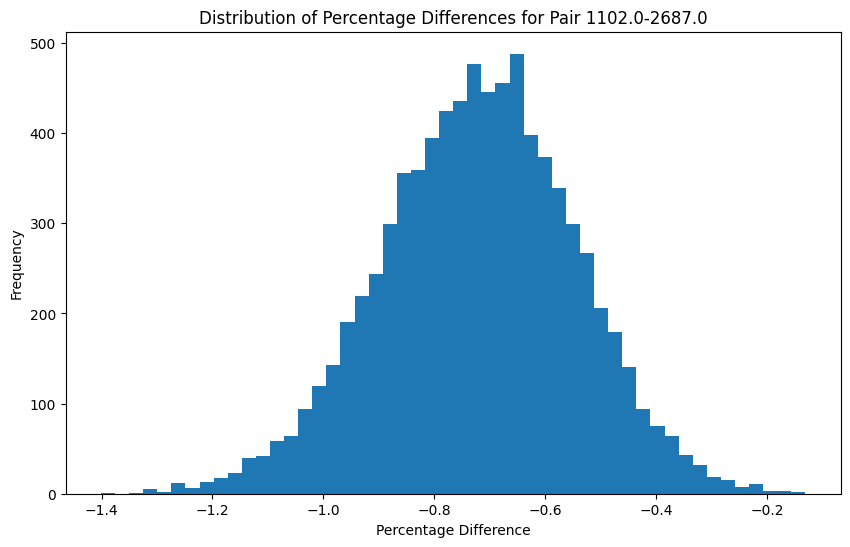

In [205]:
import numpy as np
import pandas as pd

# Assuming 'merged_df' and 'matched_pairs' are available

# Choose a single pair for analysis
sample_pair = matched_pairs.iloc[2]
test_store = sample_pair['test_store']
control_store = sample_pair['control_store']

# Extract data for this pair
test_data = merged_df[merged_df['store'] == test_store]['campaign_z_score'].values
control_data = merged_df[merged_df['store'] == control_store]['campaign_z_score'].values

# Calculate percentage difference using all samples
perc_diff = 2 * (test_data - control_data) / (np.abs(test_data) + np.abs(control_data))

# Calculate using means
test_mean = np.mean(test_data)
control_mean = np.mean(control_data)
mean_perc_diff = 2 * (test_mean - control_mean) / (np.abs(test_mean) + np.abs(control_mean))

print(f"Test Store: {test_store}, Control Store: {control_store}")
print(f"Test Mean: {test_mean:.4f}, Control Mean: {control_mean:.4f}")
print(f"Percentage Difference (using means): {mean_perc_diff:.4f}")
print(f"Mean of Percentage Differences (using all samples): {np.mean(perc_diff):.4f}")
print(f"Median of Percentage Differences (using all samples): {np.median(perc_diff):.4f}")

# Distribution of percentage differences for this pair
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(perc_diff, bins=50)
plt.title(f'Distribution of Percentage Differences for Pair {test_store}-{control_store}')
plt.xlabel('Percentage Difference')
plt.ylabel('Frequency')
plt.show()

#### Plot Every Distribution of Total Sum of Sales 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with 76 subplots arranged vertically
fig, axes = plt.subplots(nrows=76, ncols=1, figsize=(10, 300))

# Loop through each pair of test and control stores in matched_pairs
for idx, (ax, pair) in enumerate(zip(axes, matched_pairs.itertuples())):
    test_store = pair.test_store
    control_store = pair.control_store
    
    # Extract posterior distributions of sum_total_sales from merged_df for both test and control stores
    test_store_posteriors = merged_df[merged_df['store'] == test_store]['campaign_z_score'].values
    control_store_posteriors = merged_df[merged_df['store'] == control_store]['campaign_z_score'].values
    
    # Extract empirical values from check_df
    test_empirical = check_df[check_df['test_store'] == test_store]['test_z_score'].values[0]
    control_empirical = check_df[check_df['control_store'] == control_store]['control_z_score'].values[0]
    
    # Plot the posterior distributions for the test and control stores
    sns.kdeplot(test_store_posteriors, ax=ax, label=f'Test Store {test_store}', color='blue')
    sns.kdeplot(control_store_posteriors, ax=ax, label=f'Control Store {control_store}', color='orange')
    
    # Plot the empirical points as vertical lines or dots
    ax.axvline(test_empirical, color='blue', linestyle='--', label=f'Empirical Test {test_store}')
    ax.axvline(control_empirical, color='orange', linestyle='--', label=f'Empirical Control {control_store}')
    
    # Set title and legend for each plot
    ax.set_title(f'Test vs Control: {test_store} vs {control_store}', fontsize=10)
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [76]:
# Perform an inner join on both 'test_store' and 'control_store' columns
result_df = check_df.merge(matched_pairs, on=['test_store', 'control_store'], how='inner')

# result_df will contain only the rows from check_df that match with matched_pairs on both fields
result_df

,campaign_id,test_store,control_store,test_campaign_sales,control_campaign_sales,test_weekly_avg_sales_amt,control_weekly_avg_sales_amt,test_stddev_sales_amt,control_stddev_sales_amt,test_z_score,control_z_score,z_score_perc_diff,abs_perc_diff
0,WOW20001780_3,1761,7208,3220.920000000,3734.380000000,2137.493846,2133.062308,508.412445,501.854698,2.130998,3.190799,-0.332143,0.015145
1,WOW20001780_3,2564,3275,6303.610000000,5623.530000000,4755.985385,4757.869231,922.442380,927.606484,1.677747,0.933220,0.797804,0.005963
2,WOW20001780_3,1034,4600,2373.370000000,2026.800000000,1387.498462,1334.950000,327.634132,315.716514,3.009062,2.191365,0.373145,0.077111
3,WOW20001780_3,3007,5615,3084.710000000,3000.330000000,2111.933077,2122.770769,437.769372,438.118457,2.222122,2.003018,0.109387,0.005902
4,WOW20001780_3,1287,2665,5888.560000000,5870.210000000,3997.179231,4017.066154,906.383386,914.269294,2.086734,2.026912,0.029513,0.013576
5,WOW20001780_3,4365,1348,1844.250000000,3171.270000000,1778.926154,1729.301538,388.005571,373.461246,0.168358,3.861093,-0.956396,0.067641
6,WOW20001780_3,3389,1368,3930.530000000,4681.020000000,3073.201538,3081.276154,617.360664,611.170683,1.388700,2.617508,-0.469457,0.012749
7,WOW20001780_3,4387,7216,4301.180000000,5711.780000000,3611.926923,3682.167692,799.759634,792.844838,0.861825,2.559911,-0.663338,0.027797
8,WOW20001780_3,1030,1280,5275.450000000,5415.490000000,3679.665385,3700.084615,734.783238,737.293635,2.171776,2.326624,-0.066555,0.008923
9,WOW20001780_3,2563,1317,5250.890000000,4514.510000000,3087.932308,2998.419231,911.085765,944.434511,2.374044,1.605289,0.478888,0.065164


In [ ]:
check = client.query(
"""
"""
).result()
check_df = check.to_dataframe()
chime.success()
check_df 

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu_pop]
>Metropolis: [sigma_pop]
>Metropolis: [pair_effects]


Output()

/opt/homebrew/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/opt/homebrew/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


/opt/homebrew/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 11 seconds.


Model Summary:
                   mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_pop            0.027  0.054  -0.074    0.128      0.001    0.000    6773.0   
sigma_pop         0.550  0.038   0.480    0.622      0.001    0.000    4849.0   
pair_effects[0]  -0.050  0.002  -0.054   -0.047      0.000    0.000    7493.0   
pair_effects[1]   0.415  0.005   0.405    0.425      0.000    0.000    7514.0   
pair_effects[2]  -0.386  0.001  -0.389   -0.384      0.000    0.000    7709.0   
pair_effects[3]  -0.524  0.001  -0.526   -0.522      0.000    0.000    7304.0   
pair_effects[4]   0.113  0.003   0.107    0.119      0.000    0.000    6815.0   
pair_effects[5]   0.000  0.002  -0.003    0.004      0.000    0.000    7960.0   
pair_effects[6]  -0.436  0.001  -0.438   -0.434      0.000    0.000    7170.0   
pair_effects[7]   0.343  0.003   0.337    0.349      0.000    0.000    7497.0   
pair_effects[8]   0.071  0.001   0.068    0.073      0.000    0.000    7566.0   
pair_effects[

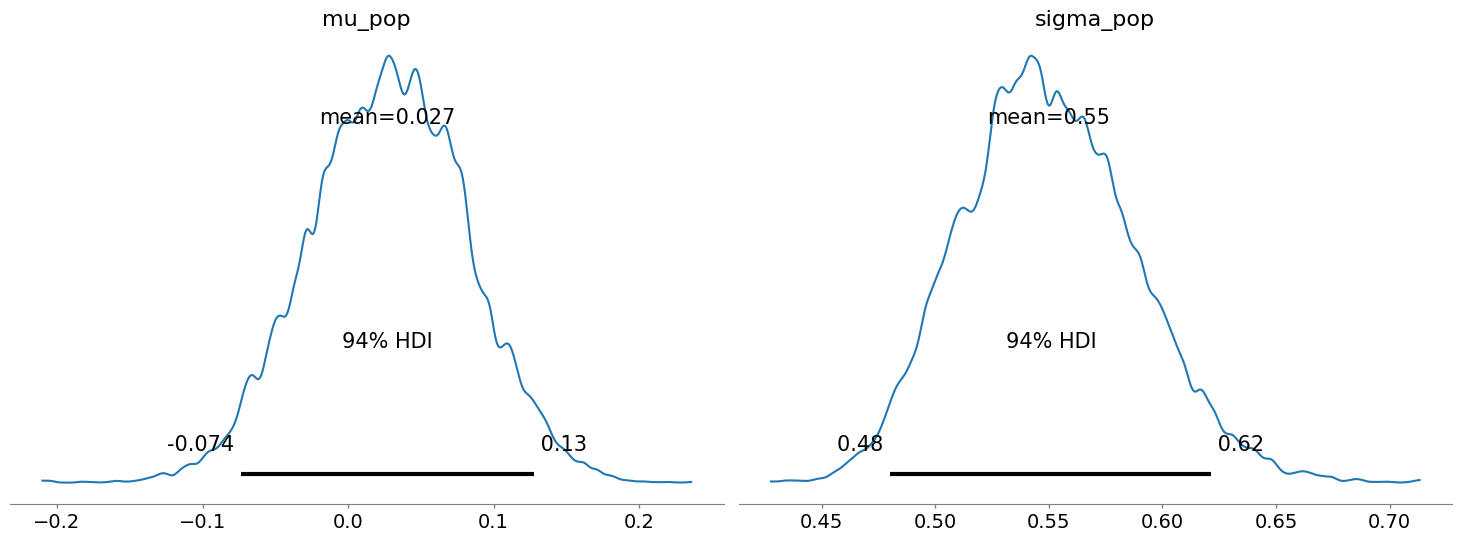

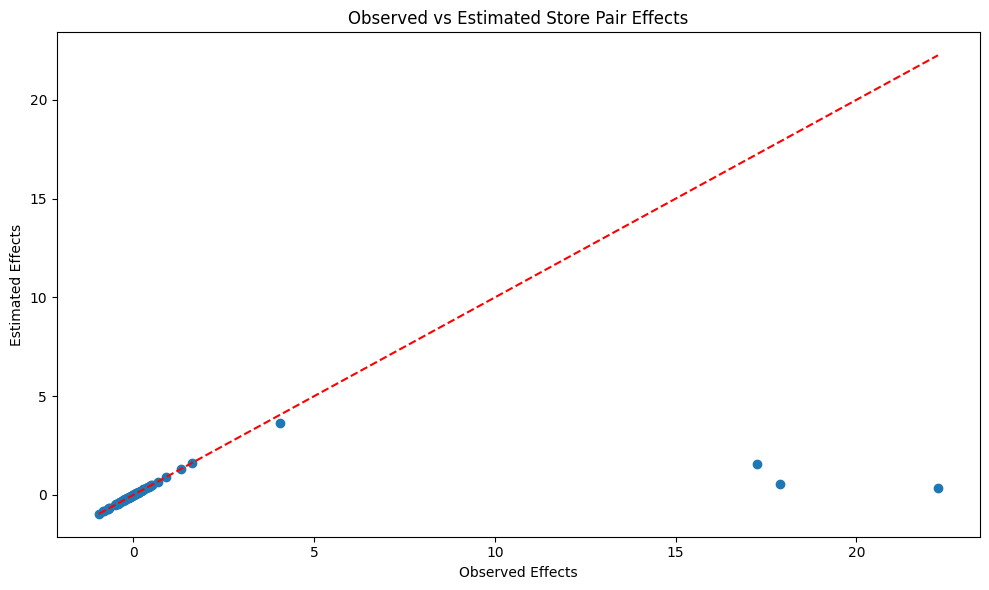

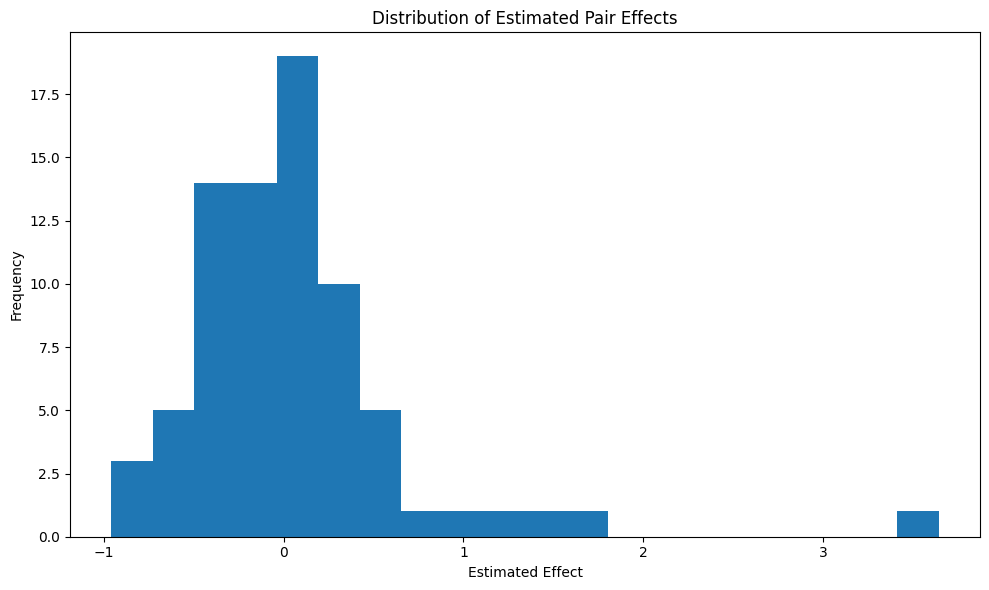

In [272]:
import pymc as pm
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

# Assuming posterior_percentage_differences_df is already created

# Calculate mean and standard error for each pair
pair_stats = posterior_percentage_differences_df.groupby(['test_store', 'control_store'])['posterior_perc_diff'].agg(['mean', 'std', 'count']).reset_index()
pair_stats['se'] = pair_stats['std'] / np.sqrt(pair_stats['count'])

# Create pair indices
pair_indices = pd.Categorical(pair_stats.apply(lambda row: f"{row['test_store']}_{row['control_store']}", axis=1)).codes

with pm.Model() as metropolis_model:
    # Population parameters
    mu_pop = pm.Normal('mu_pop', mu=0, sigma=0.1)
    sigma_pop = pm.HalfNormal('sigma_pop', sigma=0.1)
    
    # Pair effects
    pair_effects = pm.Normal('pair_effects', mu=mu_pop, sigma=sigma_pop, shape=len(pair_stats))
    
    # Likelihood
    likelihood = pm.Normal('likelihood', mu=pair_effects, sigma=pair_stats['se'], observed=pair_stats['mean'])
    
    # Use Metropolis sampler
    step = pm.Metropolis()
    trace = pm.sample(10000, step=step, tune=5000, return_inferencedata=True)

# Summarize results
summary = az.summary(trace, var_names=['mu_pop', 'sigma_pop', 'pair_effects'])
print("Model Summary:")
print(summary)

# Rename pair effects for easier interpretation
pair_effects_summary = summary[summary.index.str.startswith('pair_effects')]
pair_effects_summary.index = [f"{pair_stats['test_store'].iloc[i]}_{pair_stats['control_store'].iloc[i]}" 
                              for i in range(len(pair_stats))]

print("\nPair Effects Summary:")
print(pair_effects_summary)

# Calculate shrinkage
raw_effects = pair_stats['mean'].values
estimated_effects = pair_effects_summary['mean'].values
shrinkage = 1 - (np.var(estimated_effects) / np.var(raw_effects))
print(f"\nShrinkage: {shrinkage:.2%}")

# Plot posterior distributions
az.plot_posterior(trace, var_names=['mu_pop', 'sigma_pop'])
plt.tight_layout()
plt.show()

# Plot estimated vs observed effects
plt.figure(figsize=(10, 6))
plt.scatter(raw_effects, estimated_effects)
plt.plot([min(raw_effects), max(raw_effects)], [min(raw_effects), max(raw_effects)], 'r--')
plt.xlabel('Observed Effects')
plt.ylabel('Estimated Effects')
plt.title('Observed vs Estimated Store Pair Effects')
plt.tight_layout()
plt.show()

# Plot distribution of pair effects
plt.figure(figsize=(10, 6))
plt.hist(estimated_effects, bins=20)
plt.xlabel('Estimated Effect')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Pair Effects')
plt.tight_layout()
plt.show()

In [273]:
posterior_percentage_differences_df

,test_store,control_store,posterior_perc_diff
0,1387.0,5661.0,0.827350
1,1387.0,5661.0,1.276683
2,1387.0,5661.0,1.637823
3,1387.0,5661.0,1.619898
4,1387.0,5661.0,1.444237
...,...,...,...
607995,3194.0,2755.0,4.100429
607996,3194.0,2755.0,5.424158
607997,3194.0,2755.0,5.837885
607998,3194.0,2755.0,31.537819


In [445]:
import multiprocessing

# Get the number of CPU cores
num_cores = multiprocessing.cpu_count()

print(f"Your machine has {num_cores} CPU cores.")

# For M1/M2 Macs, you might want to distinguish between performance and efficiency cores
import platform

if platform.system() == "Darwin" and platform.machine() == "arm64":
    print("You're using an ARM-based Mac (M1/M2 series).")
    print("Note that this count includes both performance and efficiency cores.")
    print("For optimal performance in data processing tasks, you might want to use")
    print("a number slightly lower than the total core count.")

Your machine has 12 CPU cores.
You're using an ARM-based Mac (M1/M2 series).
Note that this count includes both performance and efficiency cores.
For optimal performance in data processing tasks, you might want to use
a number slightly lower than the total core count.


In [468]:
check = client.query(
    """          
with booking_count AS (
    SELECT DISTINCT
        booking_number,
        line_name,
        ROW_NUMBER() OVER() campaign_id_count
    FROM `gcp-wow-cart-data-prod-d710.cdm.dim_cartology_campaigns`
    WHERE quoteline_sku LIKE '%278258%' 
    AND media_type = 'Digital Screens Supers' 
    AND store_list IS NOT NULL 
)
SELECT 
    CONCAT(CONCAT(campaigns.booking_number, "_"), booking_count.campaign_id_count) AS booking_and_asset_number,
    media_start_date,
    campaigns.line_name, 
    CAST(store_id AS INT64) AS store_id
FROM `gcp-wow-cart-data-prod-d710.cdm.dim_cartology_campaigns` campaigns, 
UNNEST(SPLIT(store_list, ",")) AS store_id
LEFT JOIN booking_count 
    ON booking_count.booking_number = campaigns.booking_number 
    AND booking_count.line_name = campaigns.line_name
WHERE quoteline_sku LIKE '%278258%' 
AND media_type = 'Digital Screens Supers' 
AND store_list IS NOT NULL    
"""
).result()
check_df = check.to_dataframe()
check_df.head(5)

,booking_and_asset_number,media_start_date,line_name,store_id
0,WOW20014359_1,2024-09-18,CI-10178365,1030
1,WOW20014359_1,2024-09-18,CI-10178365,1032
2,WOW20014359_1,2024-09-18,CI-10178365,1073
3,WOW20014359_1,2024-09-18,CI-10178365,1112
4,WOW20014359_1,2024-09-18,CI-10178365,1120


In [463]:
bakery_stores = pd.read_csv("~/Downloads/Macro Live Test Proposal Stores They Ran Week 1.csv")
bakery_stores_joined = pd.merge(check_df, bakery_stores, left_on="store_id", right_on="test_store", how="left")
bakery_stores_joined.head(5) #[bakery_stores_joined['media_start_date'] == "2024-09-18"]

,booking_number,media_start_date,line_name,store_id,Test Type,Test Group,test_store,control_store,abs_perc_diff
0,WOW20014359,2024-09-18,CI-10178365,1030,Bakery,2.00,"1,030.00","2,654.00",0.08
1,WOW20014359,2024-09-18,CI-10178365,1032,NaN,NaN,NaN,NaN,NaN
2,WOW20014359,2024-09-18,CI-10178365,1073,Bakery,2.00,"1,073.00","5,685.00",0.03
3,WOW20014359,2024-09-18,CI-10178365,1112,Bakery,2.00,"1,112.00","3,299.00",0.14
4,WOW20014359,2024-09-18,CI-10178365,1120,Bakery,2.00,"1,120.00","3,343.00",0.18


In [480]:
check = client.query(
    """          
CREATE OR REPLACE TABLE gcp-wow-cart-data-dev-d4d7.davide.macro_bakery_live_test_1 AS 
with booking_count AS (
    SELECT DISTINCT
        booking_number,
        line_name,
        ROW_NUMBER() OVER() campaign_id_count
    FROM `gcp-wow-cart-data-prod-d710.cdm.dim_cartology_campaigns`
    WHERE quoteline_sku LIKE '%278258%' 
    AND media_type = 'Digital Screens Supers' 
    AND store_list IS NOT NULL 
)
SELECT 
    CONCAT(CONCAT(campaigns.booking_number, "_"), booking_count.campaign_id_count) AS booking_and_asset_number,
    campaigns.*
FROM `gcp-wow-cart-data-prod-d710.cdm.dim_cartology_campaigns` campaigns
LEFT JOIN booking_count 
    ON booking_count.booking_number = campaigns.booking_number 
    AND booking_count.line_name = campaigns.line_name
WHERE quoteline_sku LIKE '%278258%' 
AND media_type = 'Digital Screens Supers' 
AND store_list IS NOT NULL   
;
SELECT * FROM gcp-wow-cart-data-dev-d4d7.davide.macro_bakery_live_test_1
"""
).result()
check_df = check.to_dataframe()
check_df

,booking_and_asset_number,quote_name,booking_number,business_unit,quote_status,quote_sku,net_amount,opportunity_owner,account,line_name,media,media_location,media_type,media_start_date,media_end_date,campaign_start_date,campaign_end_date,original_campaign_start_date,original_campaign_end_date,campaign_duration_weeks,store_list,quoteline_sku,revenue_sku,quantity,media_spend,duration_weeks,opportunity_name,campaign_objective,event_name,placement,online_department,brand,sku_item_name,quoteline_category,commercial_category,cnz_category_patch,line_name_all,original_booking_number,load_dttm,compliance_media_type
0,WOW20014359_2,WOW20014359,WOW20014359,Supermarket,Stage 100%,None,"455,100.00",Alex Moses,Woolworths Own Label,CI-10178366,Digital Screens - Supers FOS - Slot 2,Screens,Digital Screens Supers,2024-09-25,2024-10-01,2024-09-11,2024-10-01,2024-09-09,2024-10-01,3,"1002,1003,1008,1056,1065,1069,1085,1087,1088,1090,1100,1104,1105,1108,1110,1118,1121,1128,1137,1138,1139,1147,1148,1152,1165,1167,1168,1171,1173,1179,1183,1184,1185,1189,1190,1192,1198,1199,1204,1208,1210,1213,1224,1228,1244,1249,1254,1261,1268,1272,1274,1275,1278,1282,1284,1287,1293,1294,1297,1302,1308,1310,1313,1316,1326,1331,1336,1338,1347,1350,1353,1368,1387,1388,1416,1434,1472,1495,1561,1574,1598,1603,1641,1645,1648,1757,1758,1767,1785,1934,1941,1997,2003,2048,2054,2065,2072,2076,2078,2082,2135,2137,2159,2234,2246,2340,2505,2506,2507,2510,2513,2516,2518,2539,2541,2544,2549,2552,2554,2556,2557,2558,2559,2560,2561,2565,2567,2570,2571,2574,2576,2577,2583,2585,2588,2590,2592,2593,2595,2597,2608,2609,2612,2617,2620,2624,2626,2631,2635,2636,2637,2638,2643,2645,2648,2651,2653,2655,2658,2661,2662,2668,2670,2680,2682,2685,2686,2690,2691,2699,2704,2708,2709,2711,2712,2714,2725,2727,2732,2741,2742,2756,2762,2764,2797,2829,2848,2853,2866,2883,2887,2900,3034,3060,3061,3066,3072,3100,3101,3108,3116,3118,3121,3123,3130,3135,3142,3143,3146,3147,3148,3151,3165,3167,3171,3172,3173,3176,3183,3184,3188,3189,3191,3196,3197,3201,3208,3219,3247,3266,3274,3275,3278,3283,3285,3289,3293,3298,3299,3310,3318,3320,3324,3325,3339,3352,3354,3361,3393,3400,3567,3604,3670,3714,3803,3804,3805,3806,3813,3850,4049,4054,4306,4313,4317,4320,4322,4328,4330,4335,4336,4343,4348,4352,4357,4359,4360,4361,4366,4370,4373,4374,4375,4379,4382,4385,4391,4394,4395,4398,4399,4611,4630,4782,4813,4855,5003,5311,5547,5603,5604,5610,5616,5617,5623,5632,5634,5635,5639,5642,5648,5649,5653,5654,5657,5673,5677,5682,5731,5798,5901,5945,7003,7004,7005,7010,7202,7203,7215,7220,7223,7582","253484,118177,104984,278258",278258,60.00,"18,000.00",1,WFC Bakery Q1 FY25,Acquire New Customers,None,None,None,WFC,None,None,None,None,"CI-10178366,",31858,2024-10-04 14:27:43.872641,None
1,WOW20014359_1,WOW20014359,WOW20014359,Supermarket,Stage 100%,None,"455,100.00",Alex Moses,Woolworths Own Label,CI-10178365,Digital Screens - Supers FOS - Slot 1,Screens,Digital Screens Supers,2024-09-18,2024-09-24,2024-09-11,2024-10-01,2024-09-09,2024-10-01,3,"1030,1032,1073,1112,1120,1131,1134,1139,1140,1143,1147,1154,1163,1180,1183,1197,1205,1209,1242,1248,1250,1258,1262,1269,1279,1325,1328,1346,1351,1368,1407,1557,1572,1598,1607,1634,1643,1649,1759,1942,2055,2190,2426,2501,2517,2523,2537,2538,2565,2568,2575,2586,2587,2589,2605,2606,2629,2634,2640,2652,2656,2660,2663,2666,2669,2749,2765,2767,2785,2797,2829,2864,2890,3063,3096,3112,3144,3181,3186,3187,3218,3222,3235,3247,3248,3260,3261,3302,3355,3357,3850,3968,4049,4308,4324,4330,4339,4350,4357,4369,4393,4397,5088,5518,5547,5606,5635,5659,5662,5679,5680,5682,5686,5691,5736,7001,7003,7008,7207,7211","253484,278258,118177,104984",278258,117.00,"35,100.00",1,WFC Bakery Q1 FY25,Acquire New Customers,None,None,None,WFC,None,None,None,None,"CI-10178365,",31858,2024-10-04 14:27:43.872641,None


In [558]:
check = client.query(
    """          
SELECT * 
FROM gcp-wow-cart-data-dev-d4d7.davide.baseline_statistics_with_campaign_macro_bakery_live_test_1 
LIMIT 20
"""
).result()
check_df = check.to_dataframe()
check_df

,campaign_id,Site,weeks_count,weekly_avg_sales_amount,stddev_sales_amount
0,WOW20014359_1,3175,2,84.194000000,46.87
1,WOW20014359_1,1800,4,9.734000000,11.57
2,WOW20014359_1,3800,4,9.922500000,4.06
3,WOW20014359_1,8882,7,9.765000000,7.25
4,WOW20014359_1,8881,7,13.480000000,11.92
5,WOW20014359_1,1393,8,7.707500000,6.07
6,WOW20014359_1,2755,8,22.895454545,26.23
7,WOW20014359_1,4435,8,71.529333333,34.67
8,WOW20014359_1,1257,11,25.104545455,15.40
9,WOW20014359_1,3805,12,112.206595745,49.70


In [555]:
check = client.query(
    """          
with booking_count AS (
    SELECT DISTINCT
        booking_number,
        media_start_date,
        CASE WHEN media_start_date = "2024-09-18" THEN 1 ELSE 2 END AS campaign_id_count
    FROM `gcp-wow-cart-data-prod-d710.cdm.dim_cartology_campaigns`
    WHERE quoteline_sku LIKE '%278258%' 
    AND media_type = 'Digital Screens Supers' 
    AND store_list IS NOT NULL 
    ORDER BY media_start_date
),
step_two AS (
SELECT 
    CONCAT(CONCAT(campaigns.booking_number, "_"), booking_count.campaign_id_count) AS booking_and_asset_number,
    campaigns.media_start_date,
    CAST(store_id AS INT64) AS store_id
FROM `gcp-wow-cart-data-prod-d710.cdm.dim_cartology_campaigns` campaigns, 
UNNEST(SPLIT(store_list, ",")) AS store_id
LEFT JOIN booking_count 
    ON booking_count.booking_number = campaigns.booking_number 
    AND booking_count.media_start_date = campaigns.media_start_date
WHERE quoteline_sku LIKE '%278258%' 
AND media_type = 'Digital Screens Supers' 
AND store_list IS NOT NULL   
) 
SELECT booking_and_asset_number, media_start_date, COUNT(DISTINCT store_id) AS n_stores FROM step_two GROUP BY 1,2
"""
).result()
check_df = check.to_dataframe()
check_df

,booking_and_asset_number,media_start_date,n_stores
0,WOW20014359_2,2024-09-25,332
1,WOW20014359_1,2024-09-18,120


In [556]:
check = client.query(
    """          
with booking_count AS (
    SELECT DISTINCT
        booking_number,
        line_name,
        CASE WHEN media_start_date = "2024-09-18" THEN 1 ELSE 2 END AS campaign_id_count
    FROM `gcp-wow-cart-data-prod-d710.cdm.dim_cartology_campaigns`
    WHERE quoteline_sku LIKE '%278258%' 
    AND media_type = 'Digital Screens Supers' 
    AND store_list IS NOT NULL 
)
SELECT 
    CONCAT(CONCAT(campaigns.booking_number, "_"), booking_count.campaign_id_count) AS booking_and_asset_number,
    media_start_date,
    campaigns.line_name, 
    CAST(store_id AS INT64) AS store_id
FROM `gcp-wow-cart-data-prod-d710.cdm.dim_cartology_campaigns` campaigns, 
UNNEST(SPLIT(store_list, ",")) AS store_id
LEFT JOIN booking_count 
    ON booking_count.booking_number = campaigns.booking_number 
    AND booking_count.line_name = campaigns.line_name
WHERE quoteline_sku LIKE '%278258%' 
AND media_type = 'Digital Screens Supers' 
AND store_list IS NOT NULL   
"""
).result()
check_df = check.to_dataframe()
bakery_stores = pd.read_csv("~/Downloads/Macro Live Test Proposal Stores We Asked Them To Run.csv")
bakery_stores_joined = pd.merge(check_df, bakery_stores, left_on="store_id", right_on="test_store", how="left")
testing = pd.DataFrame({
        'study_id': bakery_stores_joined['booking_and_asset_number'],
        'test_store': bakery_stores_joined['test_store'],
        'control_store': bakery_stores_joined['control_store'],
        'abs_perc_diff': bakery_stores_joined['abs_perc_diff']
    })
bakery_matched_pairs = testing[testing['test_store'].notna()]
bakery_matched_pairs

,study_id,test_store,control_store,abs_perc_diff
0,WOW20014359_2,"1,002.00","1,191.00",0.06
1,WOW20014359_2,"1,003.00","4,389.00",0.00
4,WOW20014359_2,"1,065.00","2,607.00",0.04
5,WOW20014359_2,"1,069.00","1,472.00",0.04
6,WOW20014359_2,"1,085.00","1,102.00",0.03
8,WOW20014359_2,"1,088.00","3,244.00",0.01
9,WOW20014359_2,"1,090.00","1,172.00",0.10
10,WOW20014359_2,"1,100.00","2,514.00",0.03
11,WOW20014359_2,"1,104.00","2,603.00",0.11
12,WOW20014359_2,"1,105.00","2,673.00",0.06


In [557]:
bakery_matched_pairs[bakery_matched_pairs['study_id'] == "WOW20014359_1"].to_csv("../Match Maker/outputs/WOW20014359_1_Global_Matching.csv")
bakery_matched_pairs[bakery_matched_pairs['study_id'] == "WOW20014359_2"].to_csv("../Match Maker/outputs/WOW20014359_2_Global_Matching.csv")

In [508]:
bakery_matched_pairs[bakery_matched_pairs['study_id'] == "WOW20014359_1"].sort_values('abs_perc_diff').head(5)

,study_id,test_store,control_store,abs_perc_diff
39,WOW20014359_1,"3,260.00","3,672.00",0.00
26,WOW20014359_1,"5,662.00","5,621.00",0.00
114,WOW20014359_1,"7,003.00","3,240.00",0.01
103,WOW20014359_1,"3,235.00","2,859.00",0.01
74,WOW20014359_1,"1,183.00","1,162.00",0.01


In [510]:
bakery_matched_pairs[(bakery_matched_pairs['abs_perc_diff'] <= 0.05) & (bakery_matched_pairs['study_id'] == "WOW20014359_1")].sort_values('abs_perc_diff')

,study_id,test_store,control_store,abs_perc_diff
39,WOW20014359_1,"3,260.00","3,672.00",0.00
26,WOW20014359_1,"5,662.00","5,621.00",0.00
114,WOW20014359_1,"7,003.00","3,240.00",0.01
103,WOW20014359_1,"3,235.00","2,859.00",0.01
74,WOW20014359_1,"1,183.00","1,162.00",0.01
35,WOW20014359_1,"1,139.00","4,386.00",0.01
93,WOW20014359_1,"1,328.00","3,058.00",0.01
47,WOW20014359_1,"2,890.00","1,351.00",0.01
55,WOW20014359_1,"1,346.00","3,177.00",0.01
24,WOW20014359_1,"2,785.00","2,514.00",0.01


In [483]:
check = client.query(
    """      
with step_one AS (
            SELECT 
                baseline.*,
                CASE WHEN test.test_store IS NULL THEN "Control" ELSE "Test" END AS test_or_control
            FROM gcp-wow-cart-data-dev-d4d7.davide.baseline_statistics_with_campaign_macro_bakery_live_test_1 baseline
            LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.test_stores_2 test
                ON TRIM(test.booking_and_asset_number) = TRIM(baseline.campaign_id)
                AND TRIM(CAST(test.test_store AS STRING)) = TRIM(CAST(baseline.Site AS STRING))
            WHERE baseline.campaign_id = 'WOW20014359_1'
        ),
        step_two AS (
            SELECT 
                test_or_control,
                COUNT(DISTINCT Site) AS n_stores, 
                COUNT(DISTINCT CASE WHEN weeks_count = 13 THEN Site ELSE NULL END) AS has_13_wks_historical_sales
            FROM step_one 
            GROUP BY 1
        )
    SELECT * FROM step_two
    """
).result()
check_df = check.to_dataframe()
check_df

,test_or_control,n_stores,has_13_wks_historical_sales


In [485]:
check = client.query(
    """      
    SELECT 
        baseline.*
        --CASE WHEN test.test_store IS NULL THEN "Control" ELSE "Test" END AS test_or_control
    FROM gcp-wow-cart-data-dev-d4d7.davide.baseline_statistics_with_campaign_macro_bakery_live_test_1 baseline
    LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.test_stores_2 test
        ON TRIM(test.booking_and_asset_number) = TRIM(baseline.campaign_id)
        AND TRIM(CAST(test.test_store AS STRING)) = TRIM(CAST(baseline.Site AS STRING))
    --WHERE baseline.campaign_id = 'WOW20014359_1'
        
    """
).result()
check_df = check.to_dataframe()
check_df

,campaign_id,Site,weeks_count,weekly_avg_sales_amount,stddev_sales_amount


In [545]:
matched_pairs = pd.read_csv(f"../Match Maker/outputs/WOW20014359_1_global_matching.csv")
check = client.query(
    """      
    with step_one AS (
    SELECT DISTINCT CAST(Site AS INT64) Site, test_or_control
    FROM gcp-wow-cart-data-dev-d4d7.davide.regularization_test_campaign_period_transactions 
    ORDER BY 1
    )
    SELECT *, ROW_NUMBER() OVER() AS row_num FROM step_one
    ;
    """
).result()
check_df = check.to_dataframe()
check_df['Site'] = check_df['Site'].astype(int)
matched_pairs['control_store'] = matched_pairs['control_store'].astype(int)
#check_df['Site'] = check_df['Site'].str.strip()
#matched_pairs['control_store'] = matched_pairs['control_store'].str.strip()
check_df_pairs = pd.merge(check_df, matched_pairs, left_on='Site', right_on='control_store', how='left')
print(check_df_pairs[check_df_pairs['study_id'].notnull()].sort_values('Site'))

      Site test_or_control  row_num  Unnamed: 0       study_id  test_store  \
28    1102         Control       29       20.00  WOW20014359_1    2,587.00   
29    1103         Control       30       82.00  WOW20014359_1    2,634.00   
55    1132         Control       56      116.00  WOW20014359_1    1,325.00   
56    1133         Control       57       89.00  WOW20014359_1    1,134.00   
78    1162         Control       79       74.00  WOW20014359_1    1,183.00   
86    1172         Control       87       37.00  WOW20014359_1    3,302.00   
88    1174         Control       89       95.00  WOW20014359_1    2,660.00   
92    1178         Control       93        2.00  WOW20014359_1    2,589.00   
129   1248         Control      130       83.00  WOW20014359_1    1,197.00   
133   1252         Control      134       94.00  WOW20014359_1    1,634.00   
134   1253         Control      135      110.00  WOW20014359_1    3,187.00   
138   1259         Control      139       57.00  WOW20014359_1  

In [549]:
matched_pairs['test_store'] = matched_pairs['test_store'].astype(int)
# Filter check_df to get stores that are actually test stores
test_stores = check_df[check_df['test_or_control'] == 'Test']
control_stores = check_df[check_df['test_or_control'] == 'Control']

# Identify the control stores in matched_pairs that ended up being test stores
invalid_control_stores = matched_pairs[matched_pairs['control_store'].isin(test_stores['Site'])]
invalid_test_stores = matched_pairs[matched_pairs['test_store'].isin(control_stores['Site'])]

# Now remove these invalid control stores from matched_pairs
corrected_matched_pairs = matched_pairs[~matched_pairs['control_store'].isin(invalid_control_stores['control_store'])]
corrected_matched_pairs = corrected_matched_pairs[~corrected_matched_pairs['test_store'].isin(invalid_test_stores['test_store'])]
# Display the corrected matched_pairs dataframe
print(corrected_matched_pairs)

     Unnamed: 0       study_id  test_store  control_store  abs_perc_diff
30           35  WOW20014359_1        1139           4386           0.01
35           40  WOW20014359_1        4049           2750           0.03
48           54  WOW20014359_1        5547           1766           0.01
56           62  WOW20014359_1        5635           2664           0.08
57           63  WOW20014359_1        1598           1335           0.03
62           69  WOW20014359_1        1368           2710           0.05
63           70  WOW20014359_1        2829           5687           0.02
67           74  WOW20014359_1        1183           1162           0.01
72           79  WOW20014359_1        5682           5622           0.02
78           85  WOW20014359_1        2797           1579           0.02
88           97  WOW20014359_1        4357           1470           0.02
96          105  WOW20014359_1        4330           2540           0.01
102         114  WOW20014359_1        7003         

In [530]:
check_df_pairs[check_df_pairs['study_id'].notnull()]

,Site,test_or_control,Unnamed: 0,study_id,test_store,control_store,abs_perc_diff


In [529]:
print("check_df['Site'] data type:", check_df['Site'].dtype)
print("matched_pairs['control_store'] data type:", matched_pairs['control_store'].dtype)

check_df['Site'] data type: object
matched_pairs['control_store'] data type: object


In [527]:
#matched_pairs = pd.read_csv(f"../Match Maker/outputs/WOW20014359_1_global_matching.csv")
matched_pairs.sort_values('control_store')

,Unnamed: 0,study_id,test_store,control_store,abs_perc_diff
17,20,WOW20014359_1,"2,587.00","1,102.00",0.04
75,82,WOW20014359_1,"2,634.00","1,103.00",0.03
104,116,WOW20014359_1,"1,325.00","1,132.00",0.03
81,89,WOW20014359_1,"1,134.00","1,133.00",0.03
67,74,WOW20014359_1,"1,183.00","1,162.00",0.01
32,37,WOW20014359_1,"3,302.00","1,172.00",0.02
86,95,WOW20014359_1,"2,660.00","1,174.00",0.04
2,2,WOW20014359_1,"2,589.00","1,178.00",0.04
76,83,WOW20014359_1,"1,197.00","1,248.00",0.02
85,94,WOW20014359_1,"1,634.00","1,252.00",0.03


In [526]:
matched_pairs = pd.read_csv(f"../Match Maker/outputs/WOW20014359_1_global_matching.csv")
check = client.query(
    """      
    SELECT DISTINCT Site, test_or_control
    FROM gcp-wow-cart-data-dev-d4d7.davide.regularization_test_campaign_period_transactions 
    ORDER BY 1
    LIMIT 50
    ;
    """
).result()
check_df = check.to_dataframe()
check_df

,Site,test_or_control
0,1002,Test
1,1003,Test
2,1004,Control
3,1008,Test
4,1024,Control
5,1030,Control
6,1032,Control
7,1034,Control
8,1052,Control
9,1056,Test


In [493]:
check = client.query(
    """      
    SELECT 
        baseline.*, 
        campaign.test_or_control 
    FROM gcp-wow-cart-data-dev-d4d7.davide.baseline_statistics_with_campaign_macro_bakery_live_test_1 baseline
    LEFT JOIN (SELECT DISTINCT campaign_id, Site, test_or_control FROM gcp-wow-cart-data-dev-d4d7.davide.regularization_test_campaign_period_transactions) campaign
        ON baseline.campaign_id = campaign.campaign_id 
        AND baseline.Site = campaign.Site
    WHERE baseline.campaign_id = 'WOW20014359_1'
    AND weeks_count = 12
    """
).result()
check_df = check.to_dataframe()
check_df

,campaign_id,Site,weeks_count,weekly_avg_sales_amount,stddev_sales_amount,test_or_control
0,WOW20014359_1,2582,12,52.916136364,35.63,Control
1,WOW20014359_1,4382,12,156.084791667,86.21,Test
2,WOW20014359_1,1208,12,205.485434783,85.88,Test
3,WOW20014359_1,3940,12,152.720638298,56.63,Control
4,WOW20014359_1,3174,12,156.255263158,68.40,Control
...,...,...,...,...,...,...
999,WOW20014359_1,7012,12,83.715208333,37.34,Control
1000,WOW20014359_1,1131,12,147.604468085,94.53,Control
1001,WOW20014359_1,2556,12,154.427500000,69.32,Test
1002,WOW20014359_1,3306,12,83.958750000,41.54,Control


In [492]:
check = client.query(
    """    
        DECLARE media_start_date_global_var DATE;
        DECLARE media_end_date_global_var DATE;
        SET media_start_date_global_var = (SELECT DISTINCT media_start_date FROM gcp-wow-cart-data-dev-d4d7.davide.macro_bakery_live_test_1 WHERE booking_and_asset_number = 'WOW20014359_1');
        SET media_end_date_global_var = (SELECT DISTINCT media_end_date FROM gcp-wow-cart-data-dev-d4d7.davide.macro_bakery_live_test_1 WHERE booking_and_asset_number = 'WOW20014359_1');  
        with step_one AS (
            SELECT 
                ass_pre_campaign.Article, 
                MIN(TXNStartDate) AS earliest_date, 
                MAX(TXNStartDate) AS latest_date, 
                trading.booking_and_asset_number AS campaign_id,
                trading.media_start_date,
                trading.media_end_date,
                ass_pre_campaign.Site, 
                DATE_TRUNC(ass_pre_campaign.TXNStartDate, WEEK(WEDNESDAY)) AS sales_week, 
                SUM(ass_pre_campaign.TotalAmountIncldTax) AS total_sales_amount

            FROM `gcp-wow-ent-im-wowx-cust-prod.adp_wowx_dm_integrated_sales_view.article_sales_summary_v` ass_pre_campaign
            
            LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.macro_bakery_live_test_1 trading
                ON ass_pre_campaign.TXNStartDate >= DATE_ADD(trading.media_start_date, INTERVAL -12 WEEK)
                AND ass_pre_campaign.TXNStartDate <= DATE_ADD(trading.media_end_date, INTERVAL -1 WEEK)
            
            INNER JOIN gcp-wow-cart-data-dev-d4d7.davide.unique_skus_2 skus 
                ON TRIM(skus.sku) = TRIM(ass_pre_campaign.Article)
                
            WHERE trading.booking_and_asset_number = 'WOW20014359_1' 
            AND LOWER(ass_pre_campaign.SalesChannelDescription) <> "online"
            AND ass_pre_campaign.TXNStartDate >= DATE_ADD(media_start_date_global_var, INTERVAL -12 WEEK)
            AND ass_pre_campaign.TXNStartDate <= DATE_ADD(media_end_date_global_var, INTERVAL -1 WEEK)
            AND ass_pre_campaign.SalesOrg = 1005
            GROUP BY ALL
        )  
        SELECT 
            campaign_id, 
            Site, 
            COUNT(DISTINCT sales_week) AS weeks_count,
            AVG(total_sales_amount) AS weekly_avg_sales_amount, 
            STDDEV(total_sales_amount) AS stddev_sales_amount 
        FROM step_one 
        GROUP BY ALL
        ; 
    
    """
).result()
check_df = check.to_dataframe()
check_df

,campaign_id,Site,weeks_count,weekly_avg_sales_amount,stddev_sales_amount
0,WOW20014359_1,2513,12,158.304791667,57.91
1,WOW20014359_1,7205,12,140.711666667,31.32
2,WOW20014359_1,3241,12,118.360833333,56.50
3,WOW20014359_1,1162,12,104.525434783,42.70
4,WOW20014359_1,3163,12,62.962702703,38.40
...,...,...,...,...,...
1008,WOW20014359_1,1115,12,105.413958333,49.70
1009,WOW20014359_1,2588,12,97.282888889,47.82
1010,WOW20014359_1,2723,12,75.504565217,39.78
1011,WOW20014359_1,4388,12,104.508541667,46.62


In [559]:
merged_df = pd.read_csv("../Match Maker/outputs/WOW20014359_1_merged_df.csv")
merged_df

,Unnamed: 0,total_sum_sales,store,test_or_control,campaign_id,stddev_sales_amount,weekly_avg_sales_amount,campaign_z_score,percentage_change
0,0,945.83,1030,Control,WOW20014359_1,77.63,180.14,9.86,4.25
1,1,"1,071.47",1030,Control,WOW20014359_1,77.63,180.14,11.48,4.95
2,2,879.31,1030,Control,WOW20014359_1,77.63,180.14,9.01,3.88
3,3,936.02,1030,Control,WOW20014359_1,77.63,180.14,9.74,4.20
4,4,914.61,1030,Control,WOW20014359_1,77.63,180.14,9.46,4.08
...,...,...,...,...,...,...,...,...,...
1695995,1695995,246.55,7222,Control,WOW20014359_1,41.65,109.99,3.28,1.24
1695996,1695996,269.18,7222,Control,WOW20014359_1,41.65,109.99,3.82,1.45
1695997,1695997,266.99,7222,Control,WOW20014359_1,41.65,109.99,3.77,1.43
1695998,1695998,242.76,7222,Control,WOW20014359_1,41.65,109.99,3.19,1.21


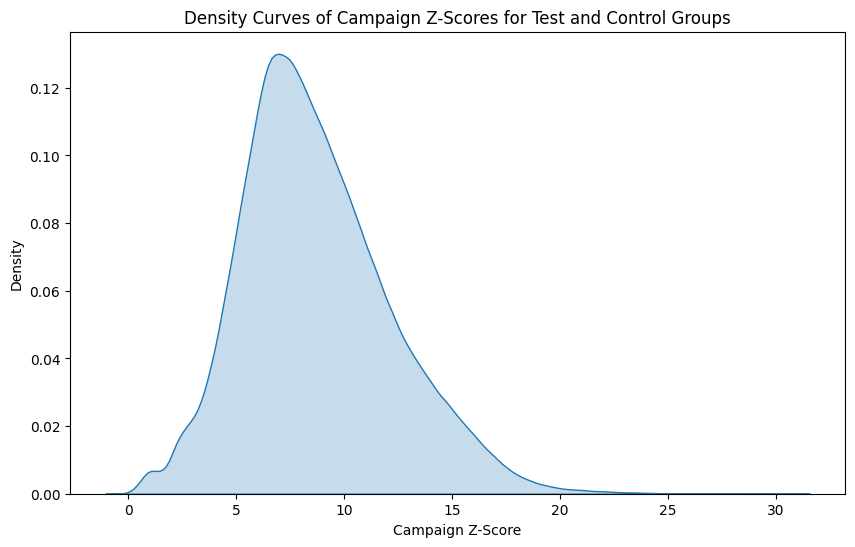

In [560]:
# Create the density plot
plt.figure(figsize=(10, 6))
sns.kdeplot(data=merged_df, x='campaign_z_score', fill='test_or_control', common_norm=False)

# Customize the plot
plt.title('Density Curves of Campaign Z-Scores for Test and Control Groups')
plt.xlabel('Campaign Z-Score')
plt.ylabel('Density')

# Display the plot
plt.show()

Summary Statistics:
Mean: -2.0015
Median: -1.9972
Std Dev: 0.7400
Min: -5.2526
Max: 1.0699
5th Percentile: -3.2188
95th Percentile: -0.7952


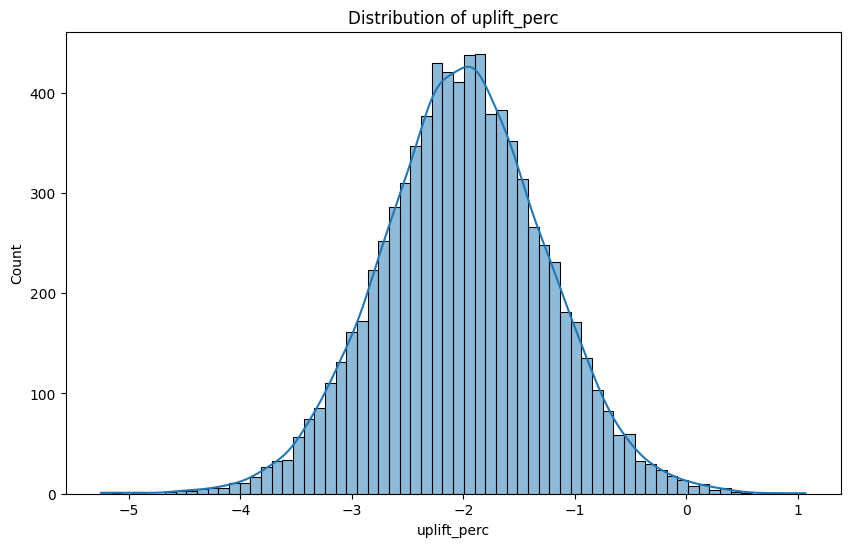

ValueError: Could not interpret value `store_pair` for `x`. An entry with this name does not appear in `data`.

<Figure size 1200x600 with 0 Axes>

In [503]:
# Summary statistics
print("Summary Statistics:")
print(f"Mean: {np.mean(pc_diff):.4f}")
print(f"Median: {np.median(pc_diff):.4f}")
print(f"Std Dev: {np.std(pc_diff):.4f}")
print(f"Min: {np.min(pc_diff):.4f}")
print(f"Max: {np.max(pc_diff):.4f}")
print(f"5th Percentile: {np.percentile(pc_diff, 5):.4f}")
print(f"95th Percentile: {np.percentile(pc_diff, 95):.4f}")

# Visualize distribution
plt.figure(figsize=(10, 6))
sns.histplot(pc_diff, kde=True)
plt.title("Distribution of uplift_perc")
plt.xlabel("uplift_perc")
plt.show()

# Boxplot by store pair
plt.figure(figsize=(12, 6))
sns.boxplot(x='store_pair', y='uplift_perc', data=merged_df)
plt.title("uplift_perc by Store Pair")
plt.xticks(rotation=90)
plt.show()

In [ ]:
#matched_pairs = pd.read_csv(f"./Match Maker/outputs/WOW20014359_1_global_matching.csv")
# check = client.query(
#     """    
#     DECLARE media_start_date_global_var DATE;
#     DECLARE media_end_date_global_var DATE;
#     SET media_start_date_global_var = (SELECT DISTINCT media_start_date FROM gcp-wow-cart-data-dev-d4d7.davide.macro_bakery_live_test_1 WHERE booking_and_asset_number = 'WOW20014359_2');
#     SET media_end_date_global_var = (SELECT DISTINCT media_end_date FROM gcp-wow-cart-data-dev-d4d7.davide.macro_bakery_live_test_1 WHERE booking_and_asset_number = 'WOW20014359_2');  


#     CREATE OR REPLACE TABLE gcp-wow-cart-data-dev-d4d7.davide.unique_skus_2 AS (
#         SELECT DISTINCT 
#             booking_and_asset_number, 
#             sku 
#         FROM gcp-wow-cart-data-dev-d4d7.davide.macro_bakery_live_test_1, 
#         UNNEST(SPLIT(quoteline_sku, ",")) AS sku 
#         WHERE booking_and_asset_number = 'WOW20014359_2'
#         AND sku IS NOT NULL
#         AND LOWER(sku) <> "npd"
#         AND sku <> ""
#     );

#     CREATE OR REPLACE TABLE gcp-wow-cart-data-dev-d4d7.davide.test_stores_2 AS (
#         SELECT DISTINCT 
#             booking_number, 
#             booking_and_asset_number,
#             test_store 
#         FROM gcp-wow-cart-data-dev-d4d7.davide.macro_bakery_live_test_1, 
#         UNNEST(SPLIT(store_list, ",")) AS test_store 
#         WHERE booking_and_asset_number = 'WOW20014359_2'
#         AND test_store IS NOT NULL
#     );


#     CREATE OR REPLACE TABLE gcp-wow-cart-data-dev-d4d7.davide.historical_performance_wow20014359_2 AS 
#             with step_one AS (
#             SELECT 
#                 ass_pre_campaign.Article, 
#                 MIN(TXNStartDate) AS earliest_date, 
#                 MAX(TXNStartDate) AS latest_date, 
#                 trading.booking_and_asset_number AS campaign_id,
#                 trading.media_start_date,
#                 trading.media_end_date,
#                 ass_pre_campaign.Site, 
#                 DATE_TRUNC(ass_pre_campaign.TXNStartDate, WEEK(WEDNESDAY)) AS sales_week, 
#                 SUM(ass_pre_campaign.TotalAmountIncldTax) AS total_sales_amount

#             FROM `gcp-wow-ent-im-wowx-cust-prod.adp_wowx_dm_integrated_sales_view.article_sales_summary_v` ass_pre_campaign
            
#             LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.macro_bakery_live_test_1 trading
#                 ON ass_pre_campaign.TXNStartDate >= DATE_ADD(trading.media_start_date, INTERVAL -12 WEEK)
#                 AND ass_pre_campaign.TXNStartDate <= DATE_ADD(trading.media_end_date, INTERVAL -1 WEEK)
            
#             INNER JOIN gcp-wow-cart-data-dev-d4d7.davide.unique_skus_2 skus 
#                 ON TRIM(skus.sku) = TRIM(ass_pre_campaign.Article)
                
#             WHERE trading.booking_and_asset_number = 'WOW20014359_2' 
#             AND LOWER(ass_pre_campaign.SalesChannelDescription) <> "online"
#             AND ass_pre_campaign.TXNStartDate >= DATE_ADD(media_start_date_global_var, INTERVAL -12 WEEK)
#             AND ass_pre_campaign.TXNStartDate <= DATE_ADD(media_end_date_global_var, INTERVAL -1 WEEK)
#             AND ass_pre_campaign.SalesOrg = 1005
#             GROUP BY ALL
#         )  
#         SELECT 
#             campaign_id, 
#             Site, 
#             COUNT(DISTINCT sales_week) AS weeks_count,
#             AVG(total_sales_amount) AS weekly_avg_sales_amount, 
#             STDDEV(total_sales_amount) AS stddev_sales_amount 
#         FROM step_one 
#         GROUP BY ALL
#     ; 

#     CREATE OR REPLACE TABLE gcp-wow-cart-data-dev-d4d7.davide.regularization_test_campaign_period_z_scores AS 
#             with step_one AS (
#                 SELECT DISTINCT
#                     trading.booking_and_asset_number AS campaign_id,
#                     trading.media_start_date,
#                     trading.media_end_date,
#                     ass_campaign_period.Site, 
#                     CASE WHEN test_stores.test_store IS NOT NULL THEN "Test" ELSE "Control" END AS test_or_control, 
#                     --ass_campaign_period.Article,
#                     ass_campaign_period.TXNStartDate,
#                     ass_campaign_period.BasketKey,
#                     TotalAmountIncldTax

#                 FROM `gcp-wow-ent-im-wowx-cust-prod.adp_wowx_dm_integrated_sales_view.article_sales_summary_v` ass_campaign_period
#                 LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.macro_bakery_live_test_1 trading
#                     ON ass_campaign_period.TXNStartDate >= trading.media_start_date 
#                     AND ass_campaign_period.TXNStartDate <= trading.media_end_date 
#                 INNER JOIN gcp-wow-cart-data-dev-d4d7.davide.unique_skus_2 skus 
#                     ON skus.sku = ass_campaign_period.Article 
#                 LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.test_stores_2 test_stores 
#                     ON CAST(test_stores.test_store AS INT64) = CAST(ass_campaign_period.Site AS INT64)
                    
#                 WHERE trading.booking_and_asset_number = 'WOW20014359_2' 
#                 AND LOWER(ass_campaign_period.SalesChannelDescription) <> "online"
#                 AND ass_campaign_period.TXNStartDate >= media_start_date_global_var
#                 AND ass_campaign_period.TXNStartDate <= media_end_date_global_var
#                 AND ass_campaign_period.SalesOrg = 1005
#             ), 
#             step_two AS (
#                 SELECT campaign_id, Site, test_or_control, SUM(TotalAmountIncldTax) AS sales_amount FROM step_one GROUP BY ALL
#             ), 
            
#             step_three AS (
#                 SELECT 
#                     step_two.campaign_id, 
#                     step_two.Site, 
#                     test_or_control,
#                     sales_amount, 
#                     (sales_amount - historical.weekly_avg_sales_amount) / historical.stddev_sales_amount AS z_score_empirical
#                 FROM step_two 
#                 LEFT JOIN gcp-wow-cart-data-dev-d4d7.davide.historical_performance_wow20014359_1 historical
#                     ON historical.Site = step_two.Site
#             ) 

#         SELECT 
#             test.campaign_id, 
#             test.Site AS test_store,
#             control.Site AS control_store,  
#             test.sales_amount AS test_sales_amount, 
#             control.sales_amount AS control_sales_amount, 
#             test.z_score_empirical AS test_empirical_z_score, 
#             control.z_score_empirical AS control_empirical_z_score,
#             ((test.z_score_empirical - control.z_score_empirical) / ABS(control.z_score_empirical)) * 100 AS z_score_empirical_comparison
#         FROM step_three test
#         LEFT JOIN step_three control 
#             ON test.test_or_control <> control.test_or_control 
#         WHERE test.test_or_control = "Test" 
#         AND control.test_or_control = "Control"     
#     ;

#     SELECT * FROM gcp-wow-cart-data-dev-d4d7.davide.regularization_test_campaign_period_z_scores;
#     """
# ).result()
# check_df = check.to_dataframe()
check_df['test_store'] = check_df['test_store'].astype(int)
check_df['control_store'] = check_df['control_store'].astype(int)
week1 = pd.read_csv("./Regularization/outputs/WOW20014359_2_comparison.csv")
#week1['test_store'] = week1['test_store'].astype(int)
#week1['control_store'] = week1['control_store'].astype(int)
week1_historical_merged = pd.merge(week1, check_df, on=("test_store", "control_store"), how="left")
week1_historical_merged


In [587]:
check = client.query(
    """    
    SELECT *
    FROM gcp-wow-cart-data-dev-d4d7.davide.macro_bakery_live_test_1
    """
).result()
check_df = check.to_dataframe()
check_df

,booking_and_asset_number,quote_name,booking_number,business_unit,quote_status,quote_sku,net_amount,opportunity_owner,account,line_name,media,media_location,media_type,media_start_date,media_end_date,campaign_start_date,campaign_end_date,original_campaign_start_date,original_campaign_end_date,campaign_duration_weeks,store_list,quoteline_sku,revenue_sku,quantity,media_spend,duration_weeks,opportunity_name,campaign_objective,event_name,placement,online_department,brand,sku_item_name,quoteline_category,commercial_category,cnz_category_patch,line_name_all,original_booking_number,load_dttm,compliance_media_type
0,WOW20014359_2,WOW20014359,WOW20014359,Supermarket,Stage 100%,None,"455,100.00",Alex Moses,Woolworths Own Label,CI-10178366,Digital Screens - Supers FOS - Slot 2,Screens,Digital Screens Supers,2024-09-25,2024-10-01,2024-09-11,2024-10-01,2024-09-09,2024-10-01,3,"1002,1003,1008,1056,1065,1069,1085,1087,1088,1090,1100,1104,1105,1108,1110,1118,1121,1128,1137,1138,1139,1147,1148,1152,1165,1167,1168,1171,1173,1179,1183,1184,1185,1189,1190,1192,1198,1199,1204,1208,1210,1213,1224,1228,1244,1249,1254,1261,1268,1272,1274,1275,1278,1282,1284,1287,1293,1294,1297,1302,1308,1310,1313,1316,1326,1331,1336,1338,1347,1350,1353,1368,1387,1388,1416,1434,1472,1495,1561,1574,1598,1603,1641,1645,1648,1757,1758,1767,1785,1934,1941,1997,2003,2048,2054,2065,2072,2076,2078,2082,2135,2137,2159,2234,2246,2340,2505,2506,2507,2510,2513,2516,2518,2539,2541,2544,2549,2552,2554,2556,2557,2558,2559,2560,2561,2565,2567,2570,2571,2574,2576,2577,2583,2585,2588,2590,2592,2593,2595,2597,2608,2609,2612,2617,2620,2624,2626,2631,2635,2636,2637,2638,2643,2645,2648,2651,2653,2655,2658,2661,2662,2668,2670,2680,2682,2685,2686,2690,2691,2699,2704,2708,2709,2711,2712,2714,2725,2727,2732,2741,2742,2756,2762,2764,2797,2829,2848,2853,2866,2883,2887,2900,3034,3060,3061,3066,3072,3100,3101,3108,3116,3118,3121,3123,3130,3135,3142,3143,3146,3147,3148,3151,3165,3167,3171,3172,3173,3176,3183,3184,3188,3189,3191,3196,3197,3201,3208,3219,3247,3266,3274,3275,3278,3283,3285,3289,3293,3298,3299,3310,3318,3320,3324,3325,3339,3352,3354,3361,3393,3400,3567,3604,3670,3714,3803,3804,3805,3806,3813,3850,4049,4054,4306,4313,4317,4320,4322,4328,4330,4335,4336,4343,4348,4352,4357,4359,4360,4361,4366,4370,4373,4374,4375,4379,4382,4385,4391,4394,4395,4398,4399,4611,4630,4782,4813,4855,5003,5311,5547,5603,5604,5610,5616,5617,5623,5632,5634,5635,5639,5642,5648,5649,5653,5654,5657,5673,5677,5682,5731,5798,5901,5945,7003,7004,7005,7010,7202,7203,7215,7220,7223,7582","118177,278258,253484,104984",278258,60.00,"18,000.00",1,WFC Bakery Q1 FY25,Acquire New Customers,None,None,None,WFC,None,None,None,None,"CI-10178366,",31858,2024-10-11 12:08:02.113,None
1,WOW20014359_1,WOW20014359,WOW20014359,Supermarket,Stage 100%,None,"455,100.00",Alex Moses,Woolworths Own Label,CI-10178365,Digital Screens - Supers FOS - Slot 1,Screens,Digital Screens Supers,2024-09-18,2024-09-24,2024-09-11,2024-10-01,2024-09-09,2024-10-01,3,"1030,1032,1073,1112,1120,1131,1134,1139,1140,1143,1147,1154,1163,1180,1183,1197,1205,1209,1242,1248,1250,1258,1262,1269,1279,1325,1328,1346,1351,1368,1407,1557,1572,1598,1607,1634,1643,1649,1759,1942,2055,2190,2426,2501,2517,2523,2537,2538,2565,2568,2575,2586,2587,2589,2605,2606,2629,2634,2640,2652,2656,2660,2663,2666,2669,2749,2765,2767,2785,2797,2829,2864,2890,3063,3096,3112,3144,3181,3186,3187,3218,3222,3235,3247,3248,3260,3261,3302,3355,3357,3850,3968,4049,4308,4324,4330,4339,4350,4357,4369,4393,4397,5088,5518,5547,5606,5635,5659,5662,5679,5680,5682,5686,5691,5736,7001,7003,7008,7207,7211","104984,278258,253484,118177",278258,117.00,"35,100.00",1,WFC Bakery Q1 FY25,Acquire New Customers,None,None,None,WFC,None,None,None,None,"CI-10178365,",31858,2024-10-11 12:08:02.113,None


NameError: name 'data_scientist' is not defined

In [589]:
check = client.query(
    """    
    SELECT 
        *
FROM `gcp-wow-wiq-ca-prod.wiqIN_DataAssets.CustomerBaseTransaction_v` 
WHERE SalesOrganisation = '1005' and BusinessDate between '2024-09-01' and '2024-09-15'
--GROUP BY 1,2
LIMIT 10
    """
).result()
check_df = check.to_dataframe()
check_df

,BusinessDate,PromotionWeekEndDate,FiscalWeekYear,TXNStartTimestamp,TransactionID,SiteNumber,SiteDescription,PostalCode,SiteCluster,Multicultural_Mix,Ethnicity_L1,CDR,CRN,IsSample,BMP,LS,NeedsType1,NeedsType1_9Segments,NeedsType2,NeedsType2_9Segments,Channel,SalesOrganisation,SalesDistrict,OnlineOrderNumber,OnlineOrderDate,OnlineOrderDeliveryDate,DeliveryType,POSNumber,CheckoutType,POSTXNNumber,BasketKey,MainShopperMission,SubShopperMission,SurveyVersion,SurveyID,DigitalNPS,DigitalOverallShoppingExperience,Article,ArticleDescription,CategoryAreaOfResponsibility,ProductNumber,MMArea,Occasion,SubOccasion,Department,DepartmentDescription,Category,CategoryDescription,SubCategory,SubCategoryDescription,Segment,SegmentDescription,SuperBrand,Brand,BrandDescription,SubBrand,TotalSize,TotalSizeUOM,PriceFamilyCode,PriceFamilyDescription,TotalAmountIncludingGST,TotalAmountExcludingGST,WOWDollar,RetailQuantity,Volume,BrandType,GBB,PAS,OfferID,PriceFocusType,Brochure,StandardPriceInclTax,Promo_Price,Discount_Dollar,Discount_Percent,SubstituteProductNumber1,SubstituteMeasure1,SubstituteProductNumber2,SubstituteMeasure2,SubstituteProductNumber3,SubstituteMeasure3,LoyaltyScore13,LoyaltyScore26,LoyaltyScore52,RepeatSolusSales52National,RepeatSolusSalesSubCategory52NationalProp,adp_source_dttm,adp_load_dttm,adp_update_dttm,start_dttm
0,2024-09-01,2024-09-03,202510.000000000,2024-09-01 00:32:53.413000+00:00,217634059,1030,Wollongong,2500,Core,Other,,Medium,3300000000001301498,None,MAINSTREAM,RETIREES,Traditional,Classic Cooks,Traditional,Classic Cooks,Online,1005,NSW,217634059,2024-09-01,2024-09-03,Home Delivery,100,None,514587408217634059,202409031414001005145874082176340591030,Full Shop,,None,None,<NA>,<NA>,764251,OzHarvest Donation 5 Dollar,,764251-EA,None,Out Of Scope,Out Of Scope,W100,NON TRADING,W10038,NON TRADE,W10038253,DONATIONS,W1003825301,CHARITY APPEALS,OZHARVEST,P,PROPRIETARY,OZHARVEST,1.00,EA,R_00764251-EA,R_00764251-EA,5.000000000,5.00,0E-9,1.000000000,1.00,NotOwnBrand,None,None,None,None,N,None,None,NaN,NaN,764248-EA,0.966917337,780181-EA,0.869974613,764445-EA,0.802469609,0.712900000,0.703700000,0.614000000,"3,096.28",0.12,2024-10-09 23:00:07,2024-10-09 23:00:07,2024-10-09 23:00:07,2024-10-09 23:00:07
1,2024-09-01,2024-09-03,202509.000000000,2024-09-01 17:28:47+00:00,20240901172847009046792574,2574,Nambour,4560,Core,Other,,Medium,None,None,None,None,None,None,None,None,In Store,1005,QLD,None,NaT,NaT,None,9,Smokeshop,4679,20240901172847009046792574,None,,None,None,<NA>,<NA>,764251,OzHarvest Donation 5 Dollar,,764251-EA,None,Out Of Scope,Out Of Scope,W100,NON TRADING,W10038,NON TRADE,W10038253,DONATIONS,W1003825301,CHARITY APPEALS,OZHARVEST,P,PROPRIETARY,OZHARVEST,1.00,EA,R_00764251-EA,R_00764251-EA,5.000000000,5.00,0E-9,1.000000000,1.00,NotOwnBrand,None,None,None,None,N,None,None,NaN,NaN,764248-EA,0.966917337,780181-EA,0.869974613,764445-EA,0.802469609,0.712900000,0.703700000,0.614000000,"3,096.28",0.12,2024-10-09 23:00:07,2024-10-09 23:00:07,2024-10-09 23:00:07,2024-10-09 23:00:07
2,2024-09-01,2024-09-03,202510.000000000,2024-09-01 10:02:29.473000+00:00,217717136,3289,Eltham,3095,Up,Other,,Low,1100000000133022249,None,PREMIUM,YOUNG FAMILIES,Conscious,Dietary Checkers,Conscious,Dietary Checkers,Online,1005,VIC,217717136,2024-09-01,2024-09-02,Dedicated Drive,100,None,2039722713217717136,2024090215220010020397227132177171363289,Full Shop,,None,None,<NA>,<NA>,780181,OzHarvest 50 Cent Meal Token,,780181-EA,None,Out Of Scope,Out Of Scope,W100,NON TRADING,W10038,NON TRADE,W10038253,DONATIONS,W1003825301,CHARITY APPEALS,OZHARVEST,P,PROPRIETARY,OZHARVEST,1.00,EA,R_00780181-EA,R_00780181-EA,0.500000000,0.50,0E-9,1.000000000,1.00,NotOwnBrand,None,None,None,None,N,None,None,NaN,NaN,764248-EA,0.939337260,309367-EA,0.702988215,764445-EA,0.663239140,0.135600000,0.167400000,0.287900000,"12,466.69",0.10,2024-10-09 23:00:07,2024-10-09 23:00:07,2024-10-09 23:00:07,2024-10-09 23:00:07
3,2024-09-01,2024-09-03,202509.000000000,2024-09-01 19:49:05+00:0

In [585]:
check_df['z_score_empirical_comparison'] = check_df['z_score_empirical_comparison'] / 100
check_df['test_store'] = check_df['test_store'].astype(int)
check_df['control_store'] = check_df['control_store'].astype(int)
week1_historical_merged = pd.merge(week1, check_df[['z_score_empirical_comparison', 'test_store', 'control_store']], on=("test_store", "control_store"), how="left")
week1_historical_merged

,campaign_id,test_store,control_store,pymc_percentage_diff,z_score_perc_diff_equivalent,z_score_empirical_comparison
0,WOW20014359_2,NaN,NaN,2.90,NaN,NaN
1,WOW20014359_2,NaN,NaN,13.10,NaN,NaN
2,WOW20014359_2,NaN,NaN,254.60,NaN,NaN
3,WOW20014359_2,"1,002.00","1,191.00",-23.80,NaN,-25.68
4,WOW20014359_2,"1,003.00","4,389.00",-24.60,NaN,-16.02
5,WOW20014359_2,"1,065.00","2,607.00",17.30,NaN,23.37
6,WOW20014359_2,"1,085.00","1,102.00",-19.10,NaN,-17.29
7,WOW20014359_2,"1,088.00","3,244.00",58.70,NaN,59.55
8,WOW20014359_2,"1,090.00","1,172.00",-18.00,NaN,-30.62
9,WOW20014359_2,"1,100.00","2,514.00",58.40,NaN,55.27
